## Regression Modelling with the Ames Housing Data

*Author : Ayesha Khatib*

### Problem Statement :
---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

### Import packages

In [146]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### 1. Load the dataset

In [2]:
# Load the housing dataset

house = pd.read_csv('./housing.csv')

### 2. EXPLORE DATA ANALYSIS (EDA)

In [3]:
# Read the housing 5 entries of the data head.

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check the shape of the data
house.shape

# ------------ORIGINAL DATASET SHAPE : 1460 Rows X 81 columns-----------

(1460, 81)

In [5]:
# Check and Print for the columns 

print(house.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
# Check data types of all variables.
house.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [7]:
# Print the summary statistics

house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### 3. Data Cleaning

In [258]:
# Data cleaning 1 : Removing any houses that are not residential from the dataset.
# Column "ZoneClassify" indicates the zoning classification of the house : FV, RH, RP, RL and RM and rest row data needs to be removed.

house.MSZoning.sort_values().value_counts() 


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### Remove row entries for "C (all)"

In [8]:
# Data cleaning 1 : From the o/p "C (all)" entries needs to be removed from the dataset.

# Option 1 : Using for loop for practice.
for index,values in enumerate(house.MSZoning):
    #print(index)
    #print(values)
    if values == 'C (all)':
        house = house.drop(index)
        
# Option 2 : house = house[house.MSZoning.str.startswith(('R','F'))]

# Verifying the rows are removed with the 10 rows removed as indicated by change in the shape.
print(house.shape)  # (1450, 81)

house.MSZoning.sort_values().value_counts() 

(1450, 81)


RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

#### Rename the columns

In [9]:
# Data Cleaning 2 : Rename the column names.
# Based on the descriptions, renaming the column names to make more sense.
# {Original column: renamed column }

rename_map = {    
'MSSubClass' : 'HouseSubClass',
'MoSold' : 'MonthSold',
'PoolQC':'PoolQual',
'ScreenPorch':'ScreenPorchArea',
'WoodDeckSF':'WoodDeckArea',
'OpenPorchSF':'OpenPorchArea',
'PavedDrive':'PavedDriveway',
'GarageCond': 'GarageCondt',
'GarageQual':'GarageQual',
'GarageCars':'GarageCarsCap',
'GarageFinish': 'GarageInterior',
'GarageYrBlt':'GarageBuiltYr',
'GarageType':'GarageLoc',
'FireplaceQu':'FireplQual',
'Fireplaces':'FireplCount',
'Functional':'Functionality',
'TotRmsAbvGrd':'TotRmsAbvGrade',
'KitchenAbvGr':'KitchAbvGrade',
'BedroomAbvGr':'BedrmAbvGrade',
'GrLivArea':'GrndLivArea',
'LowQualFinSF':'LowQualArea',
'2ndFlrSF':'2ndFlrArea',
'1stFlrSF':'1stFlrArea',
'Electrical':'ElectricalSys',
'HeatingQC':'HeatingQual',
'Heating':'HeatingType',
'TotalBsmtSF':'TotBsmtArea',
'BsmtUnfSF':'BsmtUnfinArea',
'BsmtFinSF2':'BsmtFinArea2',
'BsmtFinSF1':'BsmtFinArea1',
'Foundation':'FoundationType',
'Exterior2nd':'ExteriorType2',
'Exterior1st':'ExteriorType1',
'RoofMatl':'RoofMaterial',
'MasVnrType':'MasonVenrType',
'MasVnrArea':'MasonVenrArea',
'YearRemodAdd':'YearRemodel',
'BldgType':'HouseType',
'Condition2':'SurroundCondt2',
'Condition1':'SurroundCondt1',
'Utilities':'UtilitiesAvlType',
'Alley':'AlleyAccType',
'Street':'StreetAccType',
'MSZoning':'ZoneClassify',
'Fence':'FenceQual'
}

house.rename(columns=rename_map, inplace=True)

house.columns

Index(['Id', 'HouseSubClass', 'ZoneClassify', 'LotFrontage', 'LotArea',
       'StreetAccType', 'AlleyAccType', 'LotShape', 'LandContour',
       'UtilitiesAvlType', 'LotConfig', 'LandSlope', 'Neighborhood',
       'SurroundCondt1', 'SurroundCondt2', 'HouseType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodel', 'RoofStyle',
       'RoofMaterial', 'ExteriorType1', 'ExteriorType2', 'MasonVenrType',
       'MasonVenrArea', 'ExterQual', 'ExterCond', 'FoundationType', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinArea1',
       'BsmtFinType2', 'BsmtFinArea2', 'BsmtUnfinArea', 'TotBsmtArea',
       'HeatingType', 'HeatingQual', 'CentralAir', 'ElectricalSys',
       '1stFlrArea', '2ndFlrArea', 'LowQualArea', 'GrndLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedrmAbvGrade',
       'KitchAbvGrade', 'KitchenQual', 'TotRmsAbvGrade', 'Functionality',
       'FireplCount', 'FireplQual', 'GarageLoc', 'GarageBuiltYr',

#### Remove Missing and NAN values

https://pandas.pydata.org/pandas-docs/stable/missing_data.html

In [16]:
# Data Cleaning 3 : Dealing with missing and NAN values
# Display all the Columns with dtype=object and Return a subset of the DataFrame's columns based on the column dtypes.

col_val = house.select_dtypes(include=object)
col_val.head()

,ZoneClassify,StreetAccType,AlleyAccType,LotShape,LandContour,UtilitiesAvlType,LotConfig,LandSlope,Neighborhood,SurroundCondt1,...,GarageLoc,GarageInterior,GarageQual,GarageCondt,PavedDriveway,PoolQual,FenceQual,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [18]:
#for-loop to print all unique values of all the columns

for val in col_val.columns:
    print(val, ': ', house[val].unique())
    
# Observation : 19 columns have 'NAN' values and needs to be replaced to None but we need to look at each of the 
               #column for better understanding.

ZoneClassify :  ['RL' 'RM' 'FV' 'RH']
StreetAccType :  ['Pave' 'Grvl']
AlleyAccType :  [nan 'Grvl' 'Pave']
LotShape :  ['Reg' 'IR1' 'IR2' 'IR3']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
UtilitiesAvlType :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
SurroundCondt1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
SurroundCondt2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
HouseType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMaterial :  ['CompShg' 'WdShngl' 'Metal' 'WdShake

In [262]:
# Data Cleaning 3 : Dealing with missing and NAN values
# Display all the Columns with dtype=not an object.

col_val = house.select_dtypes(exclude=object)
for val in col_val.columns:
    print(val, ': ', house[val].unique())

Id :  [   1    2    3 ... 1458 1459 1460]
HouseSubClass :  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
LotFrontage :  [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
  73.  77.  64.  94. 105.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
LotArea :  [ 8450  9600 11250 ... 17217 13175  9717]
OverallQual :  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond :  [5 8 6 7 4 3 9 2 1]
YearBuilt :  [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1966 1959
 1994 1954

In [263]:
missing_data_obj = house.isnull().sum().sort_values(ascending= False).head(19)
missing_data_obj
#len(missing_data_obj) = 19

PoolQual          1443
MiscFeature       1398
AlleyAccType      1361
FenceQual         1172
FireplQual         681
LotFrontage        259
GarageCondt         79
GarageLoc           79
GarageBuiltYr       79
GarageInterior      79
GarageQual          79
BsmtExposure        38
BsmtFinType2        38
BsmtFinType1        37
BsmtCond            37
BsmtQual            37
MasonVenrArea        8
MasonVenrType        8
ElectricalSys        1
dtype: int64

In [19]:
# For PoolQual : Check, Replace NAN value and Verify.NAN meants "None"
# Renov_features
# Check
display(house.PoolQual.value_counts(dropna=False))

NaN    1443
Gd        3
Fa        2
Ex        2
Name: PoolQual, dtype: int64

In [20]:
# Replace
house['PoolQual'] = house['PoolQual'].fillna('None')

# Verify
house.PoolQual.value_counts(dropna=False)

None    1443
Gd         3
Fa         2
Ex         2
Name: PoolQual, dtype: int64

In [26]:
#For MiscFeature : Check, Replace NAN value and Verify.NAN meants "None"

# Check
#display(house.MiscFeature.value_counts(dropna=False))
#display(house.MiscVal.value_counts(dropna=False))

# Observation : The MiscFeature and corresponding Misc values columns with 54 non-NA values doesnot give a clear indication of 
# either a strong predictor nor inference. Hence, both columns to be dropped.

In [21]:
# To be DROPPED :
house.drop('MiscFeature',axis=1, inplace=True)
house.drop('MiscVal',axis=1, inplace=True)

# Verify
house.shape # (1450, 79)

(1450, 79)

In [22]:
#For AlleyAccType : Check, Replace NAN value and Verify.NAN meants "None"

# Check
display(house.AlleyAccType.value_counts(dropna=False))

NaN     1361
Grvl      50
Pave      39
Name: AlleyAccType, dtype: int64

In [23]:
# Replace
house['AlleyAccType'] = house['AlleyAccType'].fillna('None')

# Verify
house.AlleyAccType.value_counts(dropna=False)

None    1361
Grvl      50
Pave      39
Name: AlleyAccType, dtype: int64

In [27]:
# Check
display(house.FenceQual.value_counts(dropna=False))
# Missing values = No Fence and to replaced as 'None'

NaN      1172
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: FenceQual, dtype: int64

In [28]:
# Replace
house['FenceQual'] = house['FenceQual'].fillna('None')

# Verify
house.FenceQual.value_counts(dropna=False)

None     1172
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: FenceQual, dtype: int64

In [29]:
# Check
display(house.FireplQual.value_counts(dropna=False))
# Missing values = No Fire place and to replaced as 'None'

NaN    681
Gd     379
TA     313
Fa      33
Ex      24
Po      20
Name: FireplQual, dtype: int64

In [30]:
# Replace
house['FireplQual'] = house['FireplQual'].fillna('None')

# Verify
house.FireplQual.value_counts(dropna=False)

None    681
Gd      379
TA      313
Fa       33
Ex       24
Po       20
Name: FireplQual, dtype: int64

D:\ANACONDA\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


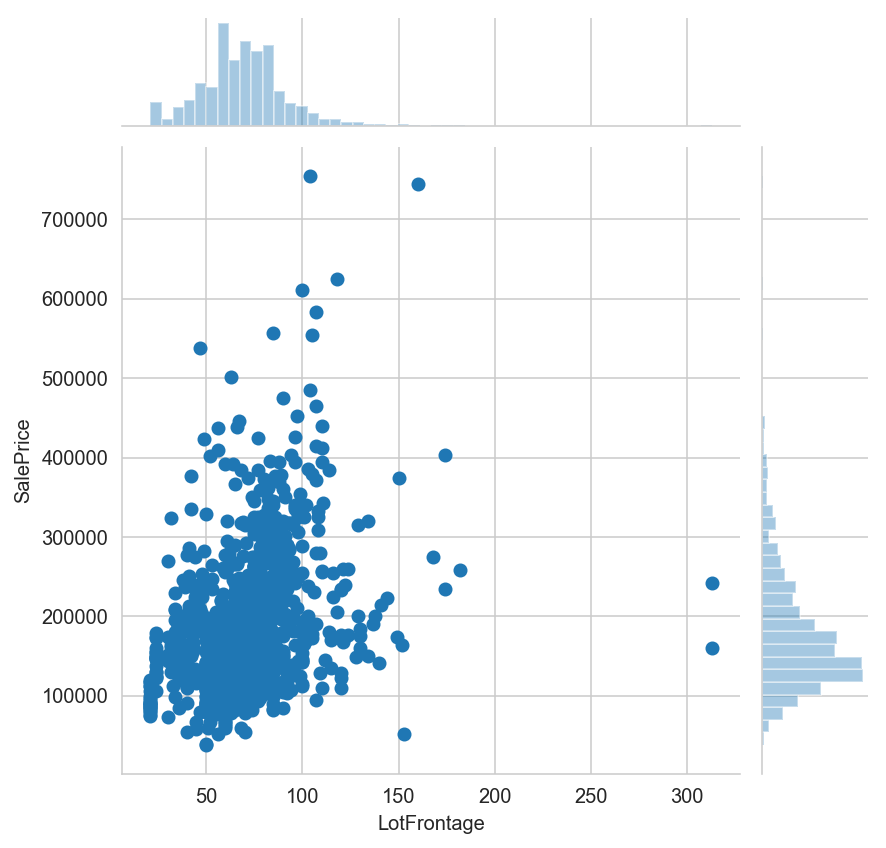

In [32]:
# To check the coorelation between Lot frontage and Sale price

sns.jointplot('LotFrontage', 'SalePrice', house[~house['LotFrontage'].isnull()])

# The coorelation is not linear and hence, we take replace NAN values with the mean or median.

In [33]:
# Check
display(house.LotFrontage.value_counts(dropna=False))

NaN       259
 60.0     139
 70.0      70
 80.0      69
 50.0      55
 75.0      53
 65.0      44
 85.0      40
 78.0      25
 21.0      23
 90.0      23
 68.0      19
 24.0      19
 64.0      19
 73.0      18
 72.0      17
 79.0      17
 63.0      17
 55.0      17
 100.0     16
 51.0      15
 74.0      15
 52.0      14
 66.0      13
 59.0      13
 67.0      12
 57.0      12
 40.0      12
 71.0      12
 43.0      12
         ... 
 134.0      2
 101.0      2
 109.0      2
 97.0       2
 124.0      2
 121.0      2
 122.0      2
 115.0      2
 114.0      2
 118.0      2
 153.0      1
 182.0      1
 140.0      1
 138.0      1
 38.0       1
 111.0      1
 150.0      1
 106.0      1
 39.0       1
 46.0       1
 144.0      1
 149.0      1
 128.0      1
 168.0      1
 112.0      1
 160.0      1
 141.0      1
 33.0       1
 152.0      1
 137.0      1
Name: LotFrontage, Length: 111, dtype: int64

In [34]:
# Replace
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
house['LotFrontage'] = house.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Verify
house.LotFrontage.value_counts(dropna=False)

60.0     148
80.0     112
70.0      94
65.0      74
73.0      70
50.0      55
75.0      53
85.0      48
71.0      38
21.0      25
74.0      25
78.0      25
68.0      23
90.0      23
52.0      21
24.0      21
64.0      19
63.0      17
72.0      17
79.0      17
55.0      17
100.0     16
51.0      15
43.0      15
91.0      14
66.0      13
59.0      13
40.0      12
67.0      12
57.0      12
        ... 
313.0      2
174.0      2
124.0      2
114.0      2
101.0      2
122.0      2
109.0      2
129.0      2
116.0      2
150.0      1
111.0      1
182.0      1
138.0      1
140.0      1
33.0       1
149.0      1
112.0      1
141.0      1
153.0      1
137.0      1
46.0       1
152.0      1
160.0      1
168.0      1
128.0      1
144.0      1
39.0       1
106.0      1
38.0       1
88.5       1
Name: LotFrontage, Length: 115, dtype: int64

In [35]:
# Check
display(house.GarageBuiltYr.value_counts(dropna=False))

NaN        79
 2005.0    65
 2006.0    59
 2004.0    53
 2003.0    50
 2007.0    49
 1977.0    35
 1998.0    31
 1999.0    30
 1976.0    29
 2008.0    29
 2000.0    27
 2002.0    26
 1968.0    26
 1950.0    24
 1993.0    22
 1966.0    21
 2009.0    21
 1965.0    21
 1962.0    21
 1958.0    20
 1996.0    20
 1957.0    20
 1970.0    20
 2001.0    20
 1954.0    19
 1997.0    19
 1978.0    19
 1960.0    19
 1974.0    18
           ..
 1926.0     6
 1916.0     5
 1936.0     5
 1922.0     5
 1928.0     4
 1931.0     4
 1935.0     4
 1946.0     4
 1945.0     4
 1982.0     4
 1938.0     3
 1924.0     3
 1921.0     3
 1932.0     3
 1923.0     3
 1910.0     3
 2010.0     3
 1952.0     2
 1947.0     2
 1918.0     2
 1929.0     2
 1914.0     2
 1915.0     2
 1934.0     2
 1937.0     2
 1942.0     2
 1906.0     1
 1927.0     1
 1908.0     1
 1933.0     1
Name: GarageBuiltYr, Length: 97, dtype: int64

In [36]:
# Here, instead of Replacing the NAN values with np.nan so as rest are integer values, drop the column "GarageBuiltYr" 
#as same house "YrBuilt"

house.drop('GarageBuiltYr',axis=1, inplace=True)

# Verify
house.columns

Index(['Id', 'HouseSubClass', 'ZoneClassify', 'LotFrontage', 'LotArea',
       'StreetAccType', 'AlleyAccType', 'LotShape', 'LandContour',
       'UtilitiesAvlType', 'LotConfig', 'LandSlope', 'Neighborhood',
       'SurroundCondt1', 'SurroundCondt2', 'HouseType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodel', 'RoofStyle',
       'RoofMaterial', 'ExteriorType1', 'ExteriorType2', 'MasonVenrType',
       'MasonVenrArea', 'ExterQual', 'ExterCond', 'FoundationType', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinArea1',
       'BsmtFinType2', 'BsmtFinArea2', 'BsmtUnfinArea', 'TotBsmtArea',
       'HeatingType', 'HeatingQual', 'CentralAir', 'ElectricalSys',
       '1stFlrArea', '2ndFlrArea', 'LowQualArea', 'GrndLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedrmAbvGrade',
       'KitchAbvGrade', 'KitchenQual', 'TotRmsAbvGrade', 'Functionality',
       'FireplCount', 'FireplQual', 'GarageLoc', 'GarageInterior'

In [275]:
# Check
#display(house.GarageQual.value_counts(dropna=False))
#display(house.GarageInterior.value_counts(dropna=False))
#display(house.GarageLoc.value_counts(dropna=False))
#display(house.GarageCondt.value_counts(dropna=False))
# Garage features all 79 values can be replaced 'None'


In [37]:
# Replace
house['GarageQual'] = house['GarageQual'].fillna('None')
house['GarageInterior'] = house['GarageInterior'].fillna('None')
house['GarageLoc'] = house['GarageLoc'].fillna('None')
house['GarageCondt'] = house['GarageCondt'].fillna('None')

# Verify
house.GarageQual.value_counts(dropna=False)

TA      1303
None      79
Fa        48
Gd        14
Po         3
Ex         3
Name: GarageQual, dtype: int64

In [277]:
#Check
# All categorical variables and missing values can be replaced to 'None'

#display(house.BsmtQual.value_counts(dropna=False))
#display(house.BsmtCond.value_counts(dropna=False))
#display(house.BsmtFinType1.value_counts(dropna=False))
#display(house.BsmtFinType2.value_counts(dropna=False))
#display(house.BsmtExposure.value_counts(dropna=False))



In [38]:
# Replace
house['BsmtQual'] = house['BsmtQual'].fillna('None')
house['BsmtCond'] = house['BsmtCond'].fillna('None')
house['BsmtFinType1'] = house['BsmtFinType1'].fillna('None')
house['BsmtFinType2'] = house['BsmtFinType2'].fillna('None')
house['BsmtExposure'] = house['BsmtExposure'].fillna('None')

# Verify
#house.BsmtQual.value_counts(dropna=False)
#house.BsmtCond.value_counts(dropna=False)
#house.BsmtFinType1.value_counts(dropna=False)
#house.BsmtFinType2.value_counts(dropna=False)
#house.BsmtExposure.value_counts(dropna=False)

In [39]:
# Check
#display(house.MasonVenrArea .value_counts(dropna=False))
# display(house.MasonVenrType.value_counts(dropna=False))

# Replace
# MasonVenrArea = 0
house['MasonVenrArea'] = house['MasonVenrArea'].fillna(0)
house['MasonVenrType'] = house['MasonVenrType'].fillna('None')


# Verify
#house.MasonVenrArea.value_counts(dropna=False)
#house.MasonVenrType.value_counts(dropna=False)

In [40]:
# Check

display(house.ElectricalSys.value_counts(dropna=False))

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: ElectricalSys, dtype: int64

In [42]:
# Replace
house['ElectricalSys'] = house['ElectricalSys'].fillna('None')
# None-- Missing data

# Verify
house.ElectricalSys.value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
None        1
Mix         1
Name: ElectricalSys, dtype: int64

In [43]:
# Drop the columns "Id" as we always have index values for reference.

house.drop(['Id'],axis=1, inplace=True)

# Verify
house.shape # (1450, 77)

(1450, 77)

<Figure size 432x288 with 0 Axes>

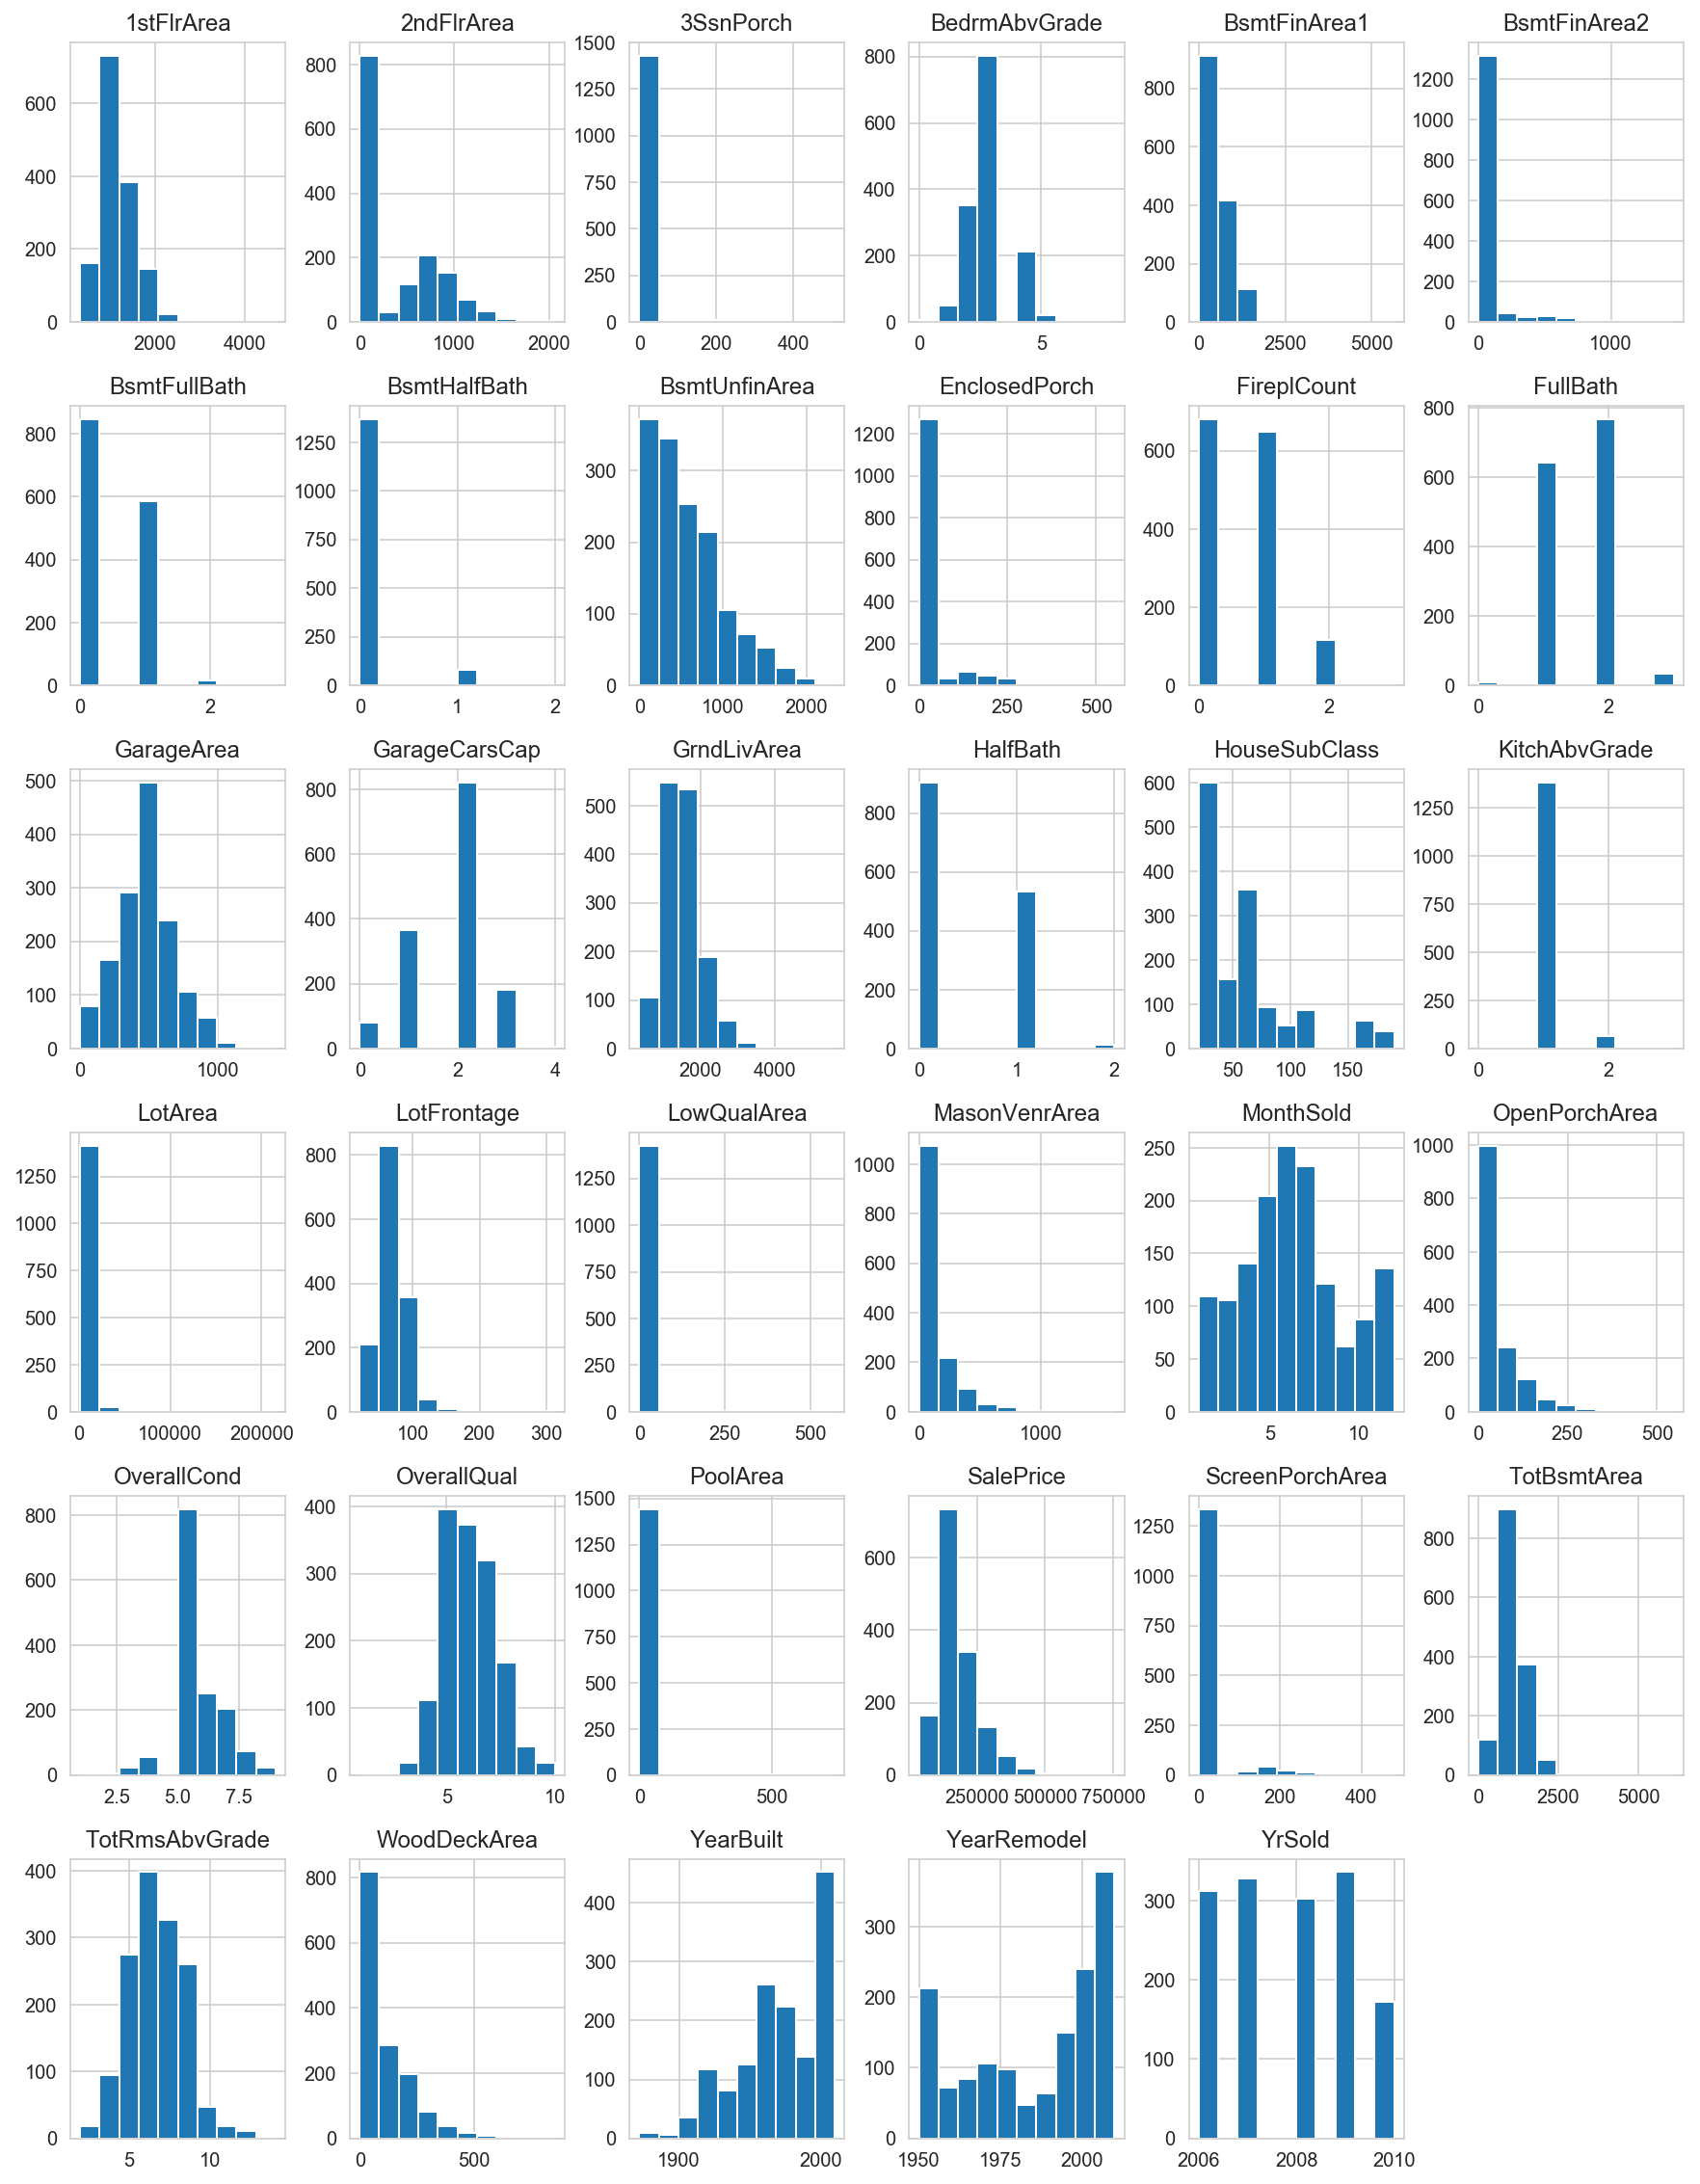

<Figure size 432x288 with 0 Axes>

In [44]:
# Data Cleaning 4 : Dealing with Outliers

# Histograms plot with all the feature variables.
# Using a Multivariate Analysis - used to visualize more than two variables at once. 

house.hist(figsize=(15,20))
plt.figure()

#Observations :
# No outlier variables : 3SsnPorch,LowQualArea,PoolArea
# Most outliers : 2ndFlrArea,BedrmAbvGrade,HouseSubClass
# Also, we dont need to remove every outlier.

In [282]:
# Data Cleaning 4 : Dealing with Outliers
# Creating a copy before running the outlier function.

house_out= pd.DataFrame()
house_out= house.copy()

house_out.shape # (1450, 77)

(1450, 77)

### Removing the Outlier

In [45]:
# Data Cleaning 4 : Dealing with Outliers
# Using the outlier function from : https://github.com/chao-li/cLiML-DataSciencePythonLibrary/blob/master/cLiML/eda.py

def findOutlier(dataframe):
    import numpy as np
    
    ## Isolate the numerical columns out of the data frame
    variables = dataframe.columns.values.tolist()
    
    num_vars = []
    for var in variables:
        if np.issubdtype(dataframe[var].dtype, np.number):
            num_vars.append(var)
        
    # for each column
    outlier_dict = {}
    for column in num_vars:
        # get the Q1 and Q3 for that column
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        # calculate the IQR
        IQR = Q3 - Q1
        # get the outliers from that column
        outliers = dataframe[[column]][(dataframe[column] < (Q1 - 1.5*IQR)) | 
                                       (dataframe[column] > (Q3 + 1.5*IQR))]
        
        value = outliers[column].unique().tolist()
        if (len(value) > 0):
            key = column
            outlier_dict[key] = value
        
    return outlier_dict

In [46]:
findOutlier(house)

{'HouseSubClass': [190, 160, 180],
 'LotFrontage': [112.0,
  115.0,
  24.0,
  21.0,
  121.0,
  122.0,
  120.0,
  134.0,
  141.0,
  174.0,
  129.0,
  140.0,
  118.0,
  116.0,
  150.0,
  111.0,
  130.0,
  137.0,
  144.0,
  114.0,
  128.0,
  149.0,
  313.0,
  168.0,
  182.0,
  138.0,
  160.0,
  152.0,
  124.0,
  153.0],
 'LotArea': [50271,
  19900,
  21000,
  21453,
  19378,
  31770,
  22950,
  25419,
  159000,
  19296,
  39104,
  19138,
  18386,
  215245,
  164660,
  20431,
  18800,
  53107,
  34650,
  22420,
  21750,
  70761,
  53227,
  40094,
  32668,
  21872,
  21780,
  25095,
  46589,
  20896,
  18450,
  21535,
  26178,
  115149,
  21695,
  53504,
  21384,
  28698,
  45600,
  17920,
  25286,
  27650,
  24090,
  25000,
  1300,
  21286,
  29959,
  23257,
  17755,
  35760,
  18030,
  35133,
  32463,
  18890,
  24682,
  23595,
  17871,
  36500,
  63887,
  20781,
  25339,
  57200,
  20544,
  19690,
  21930,
  26142],
 'OverallQual': [1],
 'OverallCond': [8, 3, 9, 2, 1],
 'YearBuilt': [188

In [47]:
# Target variable is 'Sale Price' and we need to check its correlation with other features 
# Check the predictive features to understand which feature to look closer for outliers removal.

print("The predictive features relative to target")
corr = house.corr()
corr.sort_values(["SalePrice"], ascending =False, inplace =True)
print(corr.SalePrice)

# Observation : Taking closer look at the top 6 features distribution.

The predictive features relative to target
SalePrice          1.000000
OverallQual        0.789031
GrndLivArea        0.708658
GarageCarsCap      0.642135
GarageArea         0.629831
TotBsmtArea        0.612088
1stFlrArea         0.603300
FullBath           0.556674
TotRmsAbvGrade     0.533355
YearBuilt          0.517602
YearRemodel        0.501186
MasonVenrArea      0.471056
FireplCount        0.463264
BsmtFinArea1       0.384475
LotFrontage        0.352605
OpenPorchArea      0.329491
WoodDeckArea       0.320770
2ndFlrArea         0.319774
HalfBath           0.280882
LotArea            0.264715
BsmtFullBath       0.224054
BsmtUnfinArea      0.216152
BedrmAbvGrade      0.162008
ScreenPorchArea    0.110540
PoolArea           0.092396
MonthSold          0.051987
3SsnPorch          0.043807
BsmtFinArea2      -0.014145
BsmtHalfBath      -0.017561
LowQualArea       -0.018755
YrSold            -0.025391
HouseSubClass     -0.087487
OverallCond       -0.089084
EnclosedPorch     -0.120765
Kitch

### Scatter-plot 

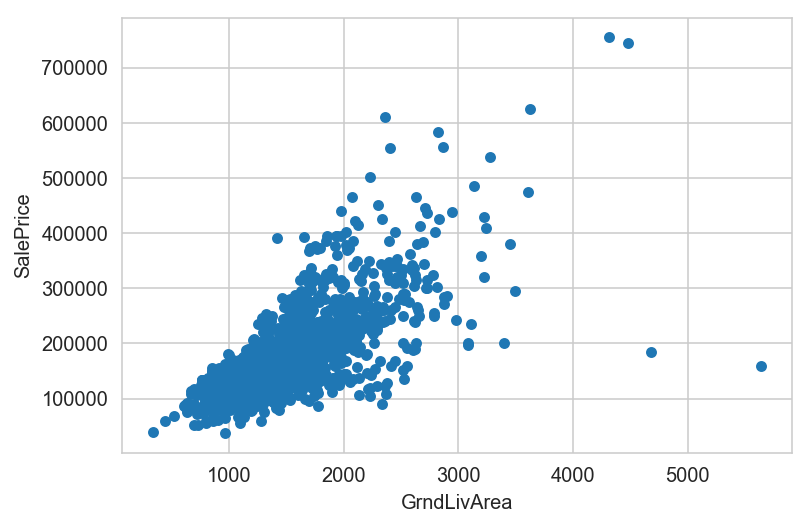

In [48]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.scatter(x = 'GrndLivArea', y = 'SalePrice')

# Observation : There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. 
# More generally,we can remove any houses with more than 4000 square feet from the dataset.
# Hence, we can remove the four outlier data points.

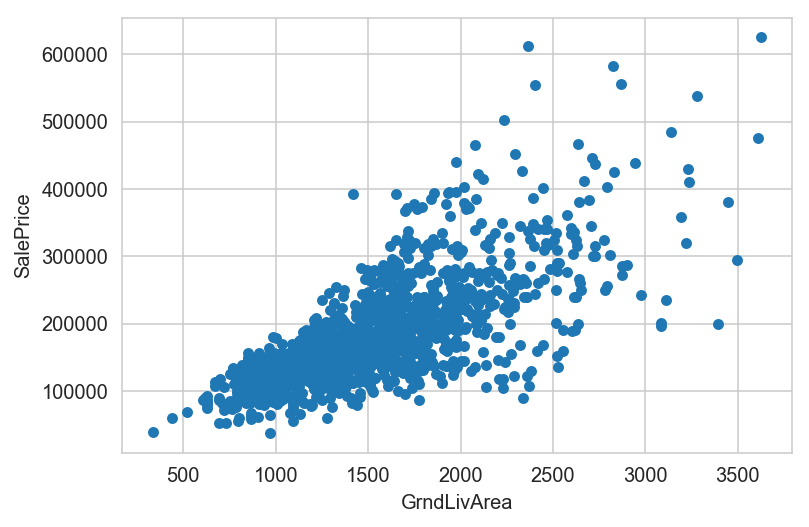

In [49]:
# Data cleaning 4 :Removing Outliers from variable - 'GrLivArea' -- two datapoints where GrLivArea > 4000

# The Outliers can be seen between greater than 4000sqft of Ground Area and above 200000
house = house.drop(house[(house.GrndLivArea > 4000) & (house.SalePrice < 250000)].index)
house = house.drop(house[(house.GrndLivArea > 4000) & (house.SalePrice > 700000)].index)

# Plot & Check. (AFTER)
house.plot.scatter(x = 'GrndLivArea', y = 'SalePrice')

# Observation : The data points have been removed but also other row data from other variables got removed as well.

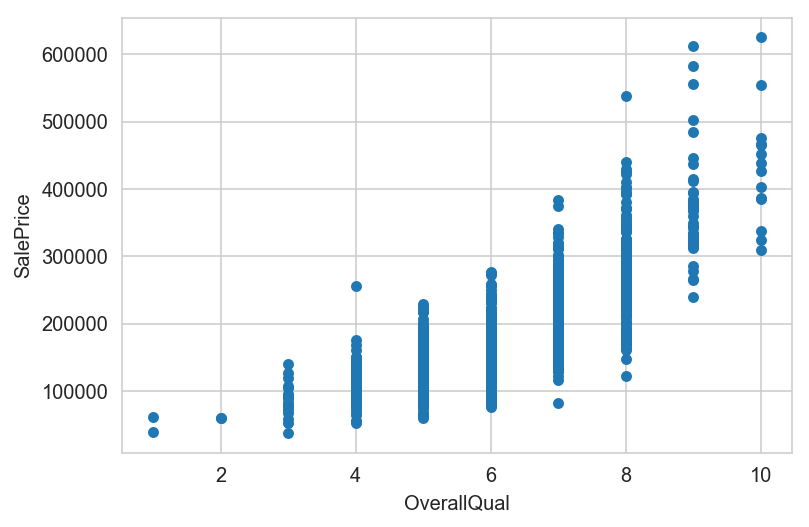

In [50]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.scatter(x = 'OverallQual', y = 'SalePrice')

# Observation : There are four outlier data points which needs to be removed.

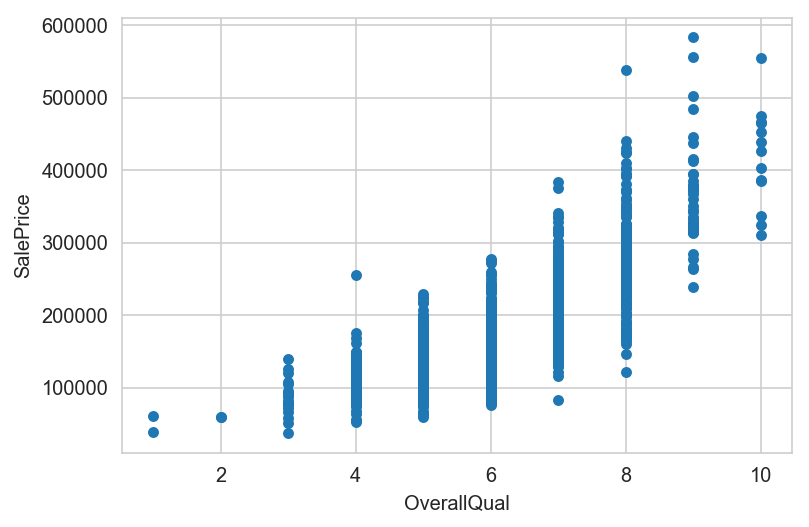

In [51]:
# Data cleaning 4 :Removing Outliers from variable - 'GrLivArea' -- two datapoints where GrLivArea > 4000

# The Outliers can be seen between greater than 4000sqft of Ground Area and above 200000
house = house.drop(house[(house.SalePrice > 600000)].index)

# Plot & Check. (AFTER)
house.plot.scatter(x = 'OverallQual', y = 'SalePrice')

# Observation : The data points above SalePrice > 600000 have been removed 
            # but also other row data from other variables got removed as well.

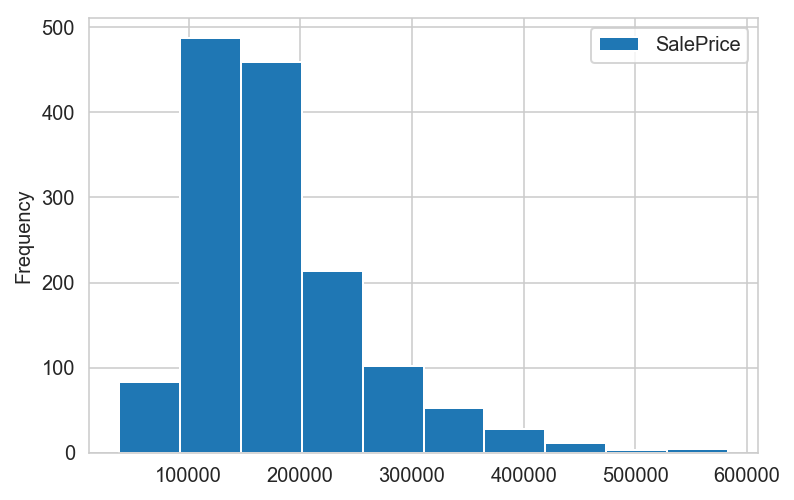

In [52]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.hist(x = 'GarageCarsCap', y = 'SalePrice')

# Observation : The data points above SalePrice > 600000 have been removed on removing from OverallQual 
            #and no further removal required.

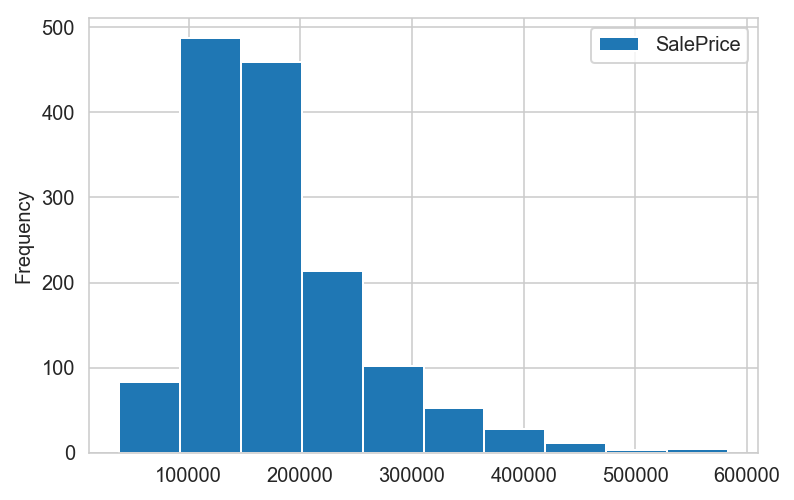

In [53]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.hist(x = 'GarageArea', y = 'SalePrice')

# Observation : The data points above SalePrice > 600000 have been removed on removing from OverallQual 
            #and no further removal required.

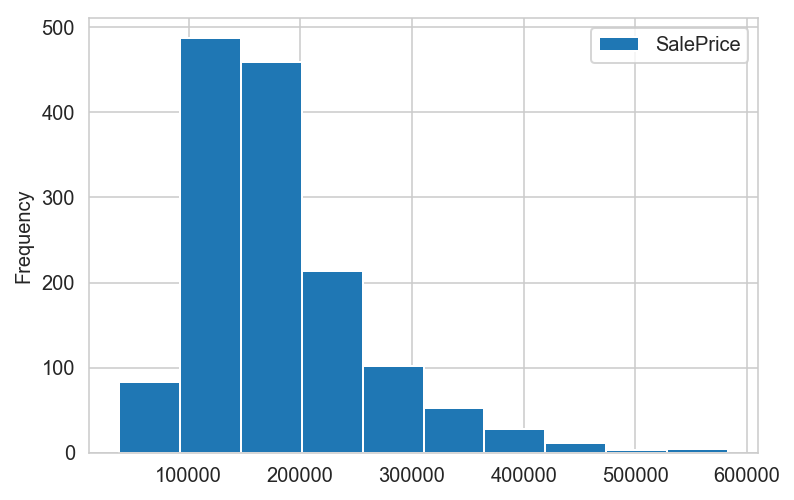

In [54]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.hist(x = 'TotBsmtArea', y = 'SalePrice')

# Observation : The data points above SalePrice > 600000 have been removed on removing from OverallQual 
            #and no further removal required.

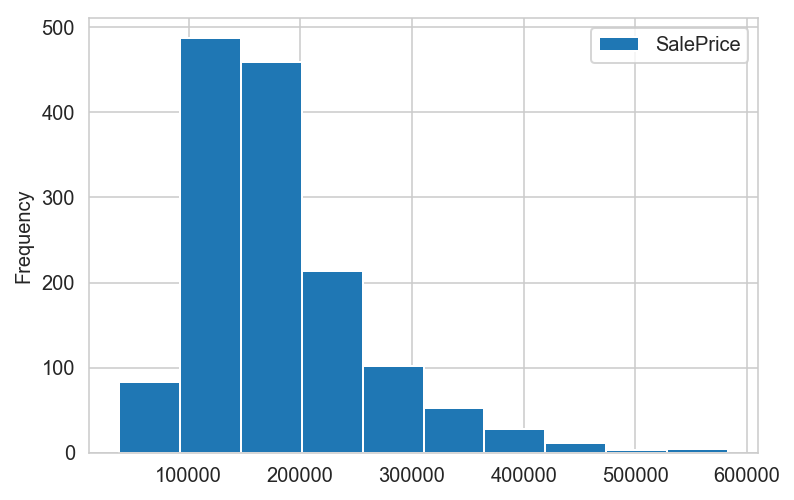

In [55]:
# Data cleaning 4 :
# Checking the plot for the main predictors

# Plot & Check. (BEFORE)
house.plot.hist(x = '1stFlrArea', y = 'SalePrice')

# Observation : The data points above SalePrice > 600000 have been removed on removing from OverallQual 
            #and no further removal required.

In [56]:
# Check the shape of the house dataframe after all outliers removal.

house.shape # (1444, 77)

(1444, 77)

In [57]:
# ---- Back-up house after all Data cleaning-----

house_clean = pd.DataFrame()

house_clean = house.copy()

# Verify shape as original
house_clean.shape # (1444, 78)


(1444, 77)

In [58]:
# Data cleaning 5 : Renaming the column names
# Defining fixed features as a new data frame with Columns variables which won't be affected due to house renovation.

d = {'HouseSubClass' : [],'ZoneClassify': [], 'LotFrontage': [], 'LotArea' : [],'StreetAccType' : [], 'LotShape' : [],
     'LandContour' : [],'UtilitiesAvlType' : [], 'LotConfig' : [],'LandSlope' : [],'Neighborhood' : [],'SurroundCondt1' : [],
     'SurroundCondt2' : [],'HouseType' : [], 'HouseStyle' : [], 'YearBuilt' : [],  'MasonVenrType' : [],
     'FoundationType' : [], 'MasonVenrArea' : [],'BsmtExposure' : [],'LowQualArea' : [],'BsmtFinArea1' : [],'BsmtFinArea2' : [],
     'BsmtUnfinArea' : [],'TotBsmtArea' : [],'1stFlrArea' : [],'2ndFlrArea': [], 'GrndLivArea': [], 'BsmtFullBath' : [],
     'BsmtHalfBath' : [], 'FullBath' : [],'HalfBath' : [],'BedrmAbvGrade' : [], 'TotRmsAbvGrade' : [],
     'GarageLoc' : [],'GarageCarsCap' : [],'GarageArea' : [],'WoodDeckArea' : [],'OpenPorchArea' : [],'EnclosedPorch': [], 
     '3SsnPorch': [], 'ScreenPorchArea' : [],'PoolArea' : [],'MonthSold' : [],'SaleType' : [],'YearRemodel': [], 'YrSold' : [],
     'SaleCondition' : [],'SalePrice' :[]}


fixed_df = pd.DataFrame(data=d)
fixed_df.head()

,HouseSubClass,ZoneClassify,LotFrontage,LotArea,StreetAccType,LotShape,LandContour,UtilitiesAvlType,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorchArea,PoolArea,MonthSold,SaleType,YearRemodel,YrSold,SaleCondition,SalePrice


In [59]:
# Copying the values from house to fixed_df to all columns.

fixed_df['HouseSubClass'] = house['HouseSubClass']
fixed_df['ZoneClassify'] = house['ZoneClassify'] 
fixed_df['LotFrontage'] = house['LotFrontage']
fixed_df['LotArea'] = house['LotArea'] 
fixed_df['StreetAccType'] = house['StreetAccType'] 
fixed_df['LotShape'] = house['LotShape'] 
fixed_df['LandContour'] = house['LandContour'] 
fixed_df['UtilitiesAvlType'] = house['UtilitiesAvlType'] 
fixed_df['LotConfig'] = house['LotConfig'] 
fixed_df['LandSlope'] = house['LandSlope'] 
fixed_df['Neighborhood'] = house['Neighborhood'] 
fixed_df['SurroundCondt1'] = house['SurroundCondt1'] 
fixed_df['SurroundCondt2'] = house['SurroundCondt2']
fixed_df['HouseType'] = house['HouseType'] 
fixed_df['HouseStyle'] = house['HouseStyle'] 
fixed_df['YearBuilt'] = house['YearBuilt']
fixed_df['YearRemodel'] = house['YearRemodel'] 
fixed_df['MasonVenrType'] = house['MasonVenrArea']
fixed_df['MasonVenrArea'] = house['MasonVenrArea'] 
fixed_df['FoundationType'] = house['FoundationType'] 
fixed_df['BsmtExposure' ] = house['BsmtExposure']
fixed_df['LowQualArea'] = house['LowQualArea'] 
fixed_df['BsmtFinArea1'] = house['BsmtFinArea1'] 
fixed_df['BsmtFinArea2'] = house['BsmtFinArea2'] 
fixed_df['BsmtUnfinArea'] = house['BsmtUnfinArea'] 
fixed_df['TotBsmtArea'] = house['TotBsmtArea'] 
fixed_df['1stFlrArea'] = house['1stFlrArea'] 
fixed_df['2ndFlrArea'] = house['2ndFlrArea']
fixed_df['GrndLivArea'] = house['GrndLivArea']
fixed_df['BsmtFullBath'] = house['BsmtFullBath'] 
fixed_df['BsmtHalfBath'] = house['BsmtHalfBath'] 
fixed_df['FullBath'] = house['FullBath'] 
fixed_df['HalfBath'] = house['HalfBath'] 
fixed_df['BedrmAbvGrade'] = house['BedrmAbvGrade'] 
fixed_df['TotRmsAbvGrade'] = house['TotRmsAbvGrade'] 
fixed_df['GarageLoc'] = house['GarageLoc'] 
fixed_df['GarageCarsCap'] = house['GarageCarsCap'] 
fixed_df['GarageArea'] = house['GarageArea']
fixed_df['WoodDeckArea'] = house['WoodDeckArea'] 
fixed_df['OpenPorchArea'] = house['OpenPorchArea'] 
fixed_df['EnclosedPorch'] = house['EnclosedPorch'] 
fixed_df['3SsnPorch'] = house['3SsnPorch']
fixed_df['ScreenPorchArea' ] = house['ScreenPorchArea']
fixed_df['PoolArea' ] = house['PoolArea']
fixed_df['MonthSold' ] = house['MonthSold']
fixed_df['YrSold' ] = house['YrSold']
fixed_df['SaleType' ] = house['SaleType']
fixed_df['SaleCondition'] = house['SaleCondition']
fixed_df['SalePrice'] = house['SalePrice']

fixed_df.shape # (1446, 49)

(1444, 49)

In [60]:
fixed_df.columns

Index(['HouseSubClass', 'ZoneClassify', 'LotFrontage', 'LotArea',
       'StreetAccType', 'LotShape', 'LandContour', 'UtilitiesAvlType',
       'LotConfig', 'LandSlope', 'Neighborhood', 'SurroundCondt1',
       'SurroundCondt2', 'HouseType', 'HouseStyle', 'YearBuilt',
       'MasonVenrType', 'FoundationType', 'MasonVenrArea', 'BsmtExposure',
       'LowQualArea', 'BsmtFinArea1', 'BsmtFinArea2', 'BsmtUnfinArea',
       'TotBsmtArea', '1stFlrArea', '2ndFlrArea', 'GrndLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedrmAbvGrade',
       'TotRmsAbvGrade', 'GarageLoc', 'GarageCarsCap', 'GarageArea',
       'WoodDeckArea', 'OpenPorchArea', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorchArea', 'PoolArea', 'MonthSold', 'SaleType', 'YearRemodel',
       'YrSold', 'SaleCondition', 'SalePrice'],
      dtype='object')

### Target variable (y) = SalePrice and Feature variable = Fixed variables that predict the Sales price.

1. We can decide that by calculating their correlation and plotting its Heatmap.
2. Using the regularization methods Lasso and Elastic Net for feature selection.
3. Features with highest co-efficeints will affect target variable most and hence, can predict the house sales price.


In [63]:
# Creating a new dataframe for data manipulation.

fixed_features = pd.DataFrame()
fixed_features = fixed_df.copy(deep=True)
#fixed_features.head()

In [64]:
# Define the target variable(y)

target_y = pd.DataFrame(data=fixed_df.SalePrice)

In [65]:
# Define feature variable (X)

feature_X = pd.DataFrame(data=fixed_df, columns=fixed_features.columns)

# Drop the SalePrice columns
feature_X.drop('SalePrice', axis=1, inplace=True)

In [66]:
# Checking all values of target variable.
target_y.describe()

,SalePrice
count,1444.000000
mean,180275.802632
std,74703.828037
min,37900.000000
25%,130000.000000
50%,163500.000000
75%,214000.000000
max,582933.000000


D:\ANACONDA\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


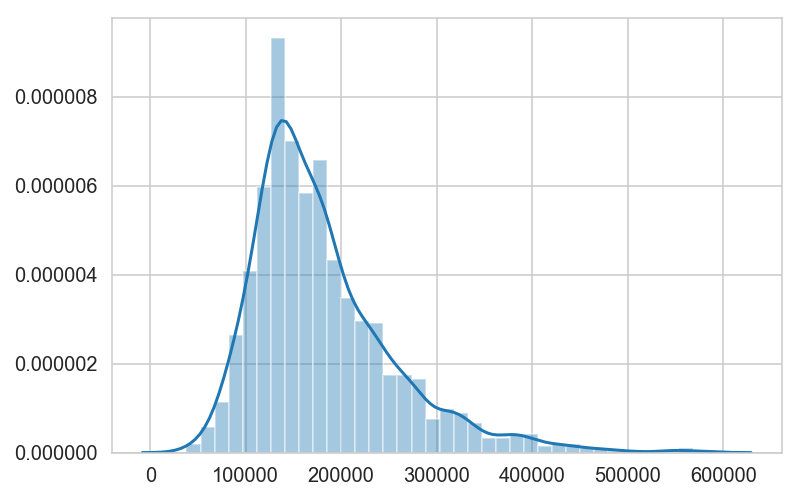

In [67]:
# Plot the SalePrice histogram.
sns.distplot(target_y, hist=True)

# Observation : The SalePrice target variable distribution looks slight right skewed.

D:\ANACONDA\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Target Variable')

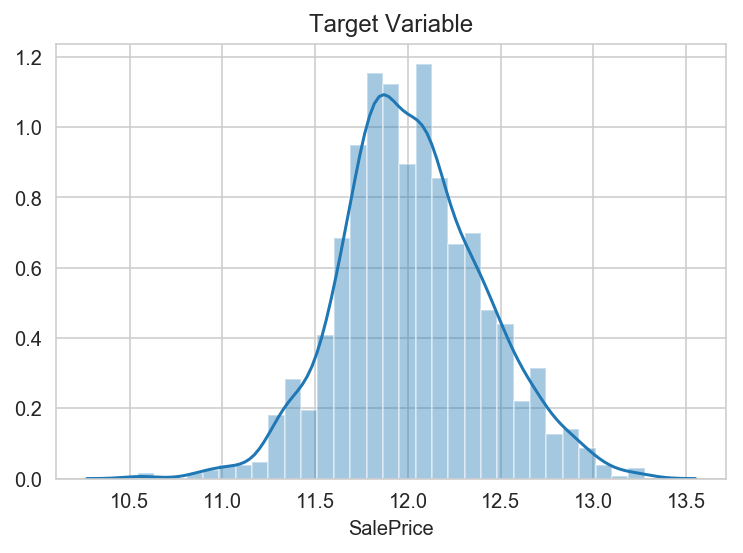

In [68]:
# Plot the target variable on a log scale using numpy log function

# log_data = np.log(data)
target_y['SalePrice'] = np.log1p(target_y['SalePrice'])

# Checking the new distribution 
sns.distplot(target_y.SalePrice , hist=True)
plt.title("Target Variable")


# Observation : The SalePrice target variable distribution looks now normally distributed.

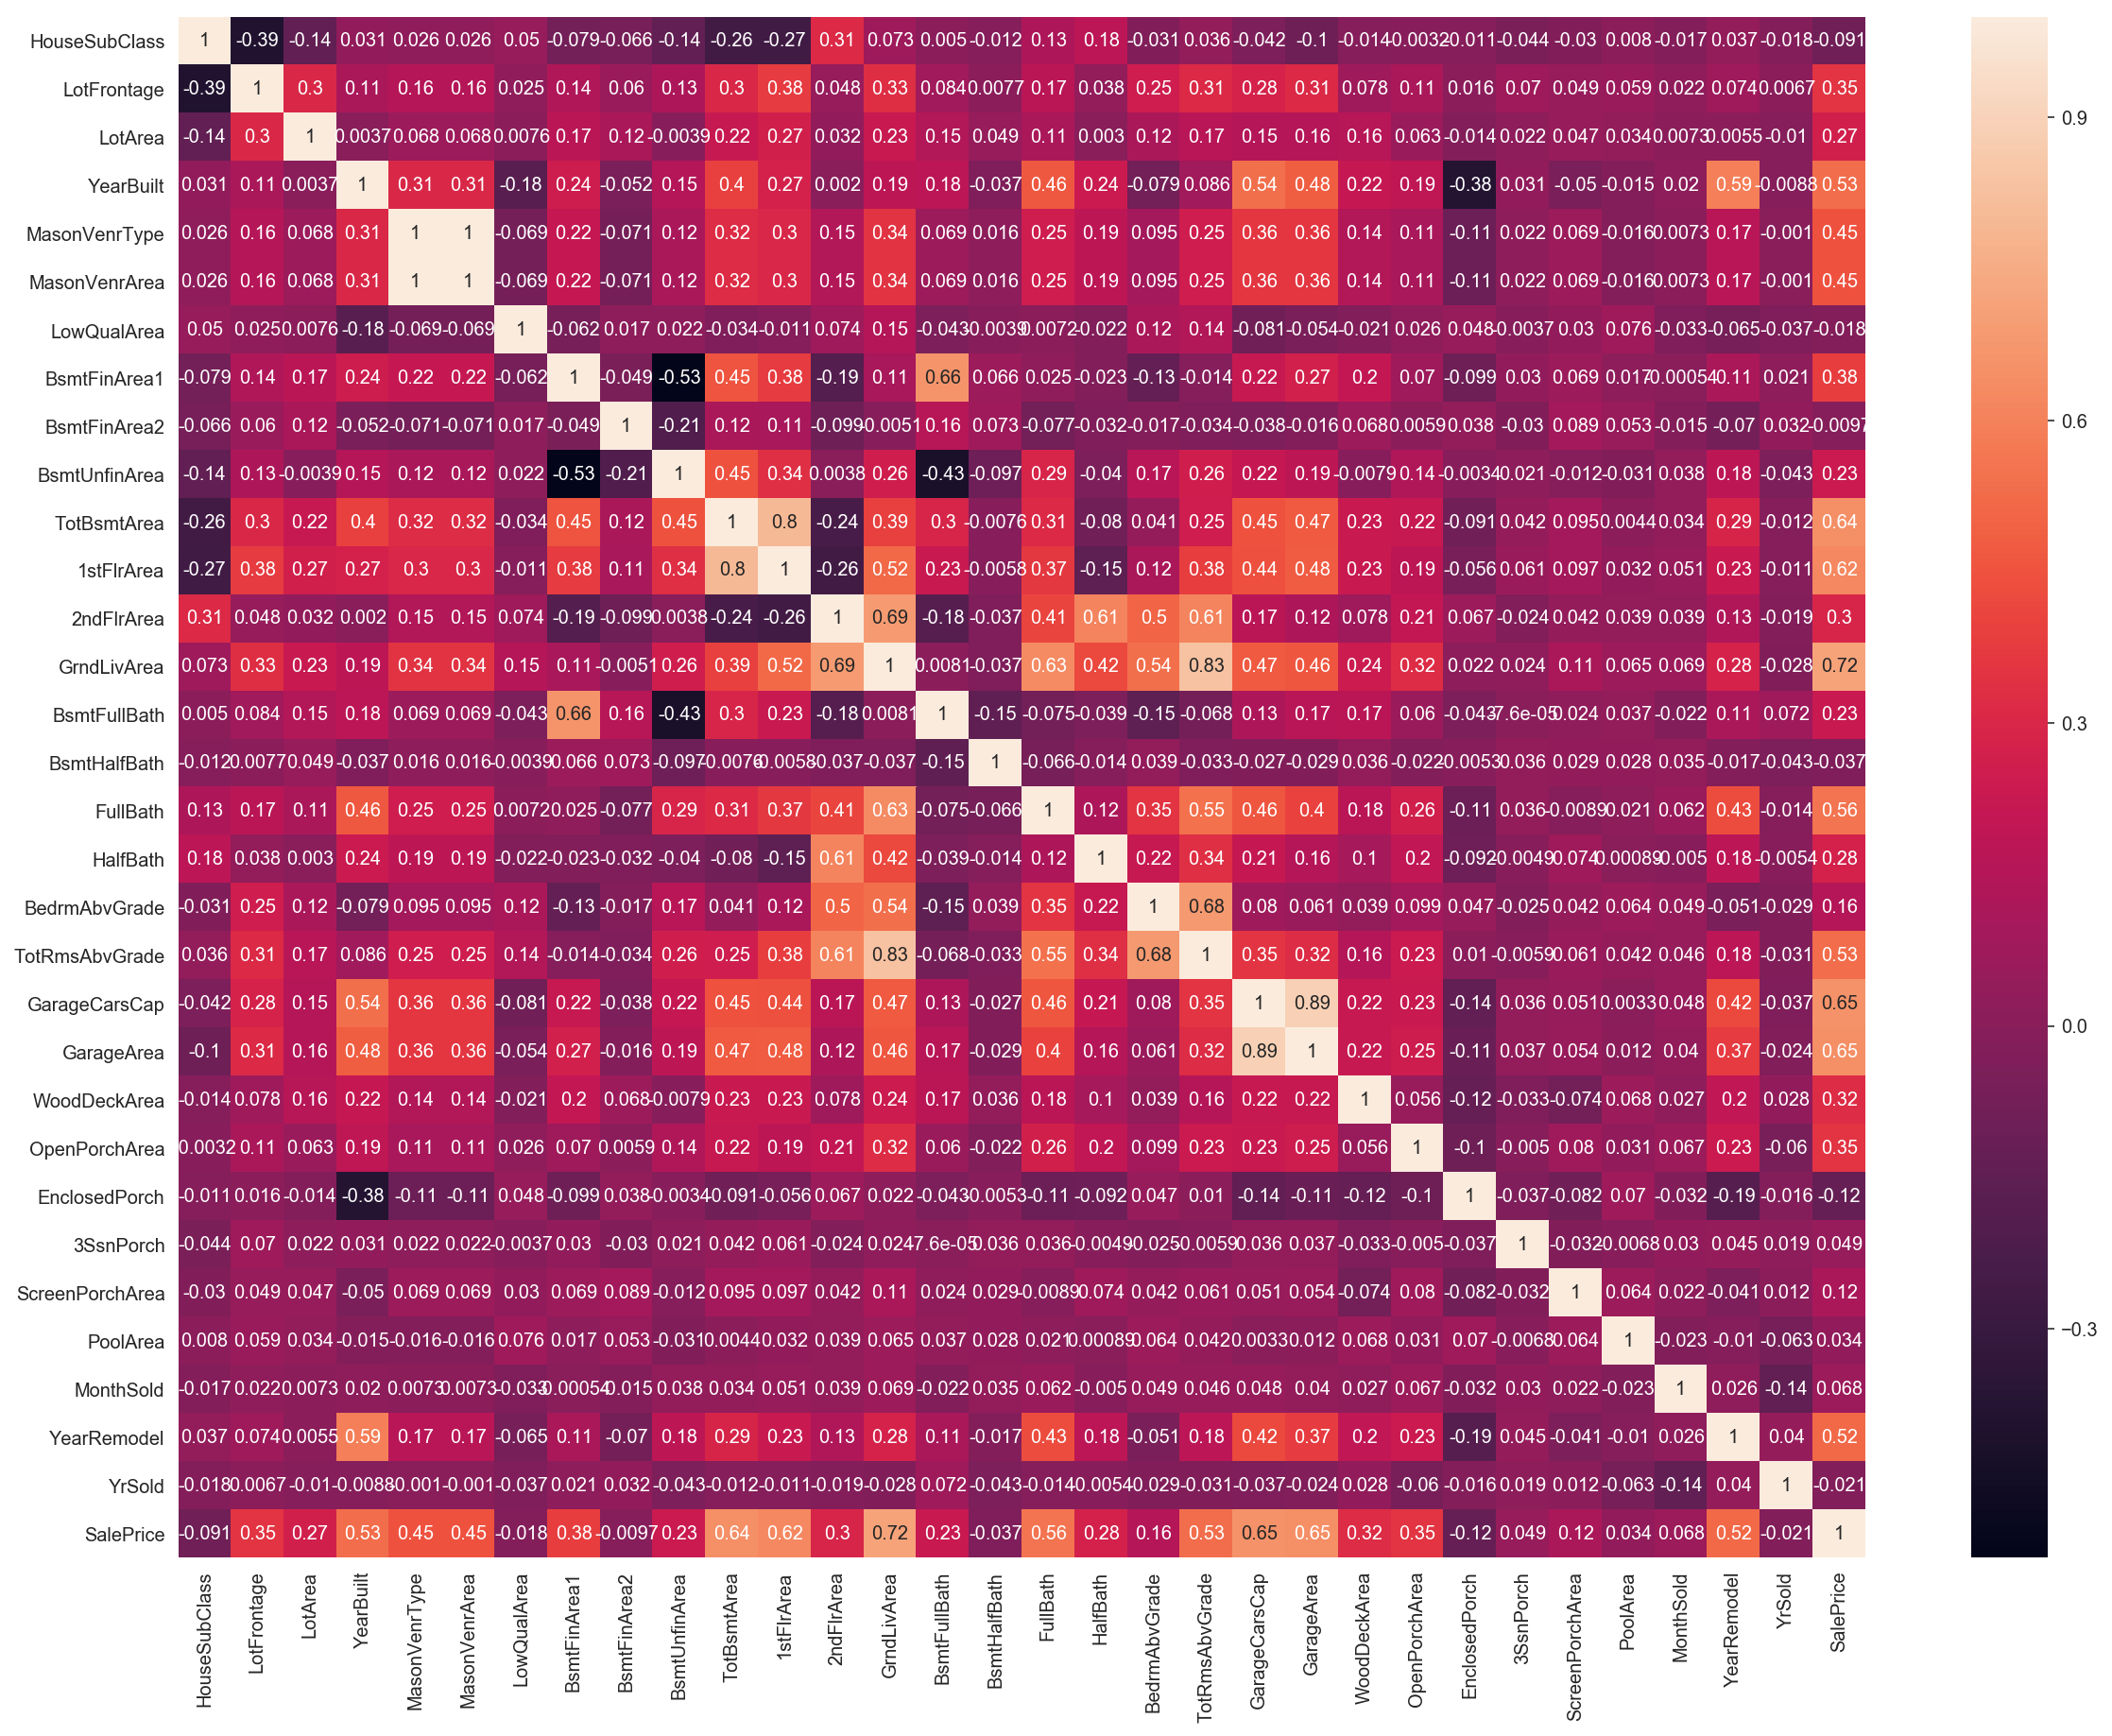

In [69]:
# Plotting them using heatmap of the fixed features

plt.figure(figsize=(20,15))

corr = fixed_df.corr()

sns.heatmap(corr, annot=True)

# Observations : 
# MasonVenrType and MasonVenrArea are coorelated.
# TotalBsmtArea and 1stFlrArea are highly coorelated as well with 0.8.
# GarageArea and GarageCarsCap  are highly coorelated as well with 0.89.

In [70]:
# Creating another Dataframe from the main housing df.
var2 = {'SalePrice':[],'GrndLivArea':[]}
SP_df = pd.DataFrame(data=var2)

SP_df['SalePrice'] = fixed_df['SalePrice']
SP_df['GrndLivArea'] = fixed_df['GrndLivArea']

SP_df.head(5)

,SalePrice,GrndLivArea
0,208500,1710
1,181500,1262
2,223500,1786
3,140000,1717
4,250000,2198


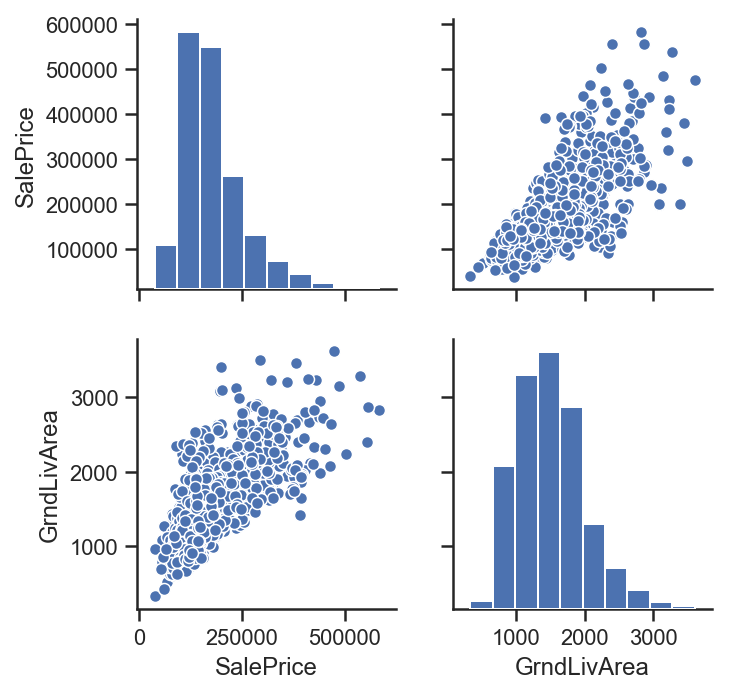

In [71]:
# Plotting a pair plot between the two feature variables and target variable.
sns.set(style='ticks',color_codes=True)
sns.pairplot(SP_df)

#Observations : 
#Positive correlation between GrLivArea and SalePrice.

- According to heatmap,the pairs 'GrLivArea' - 'TotRmsAbvGrd', 'GarageArea' - 'GarageCars', '1stFlrSF' - 'TotalBsmtSF' and 'GrLivArea' - '2ndFlrSF' shows linear relationship with eachother.
- Since,our target variable is the SalePrice,it is important to check the relationship between the target variable and these features.
- So,from this heatmap it is clear that 'GrLivArea','GarageCars', 'TotalBsmtSF' are correlated with the SalePrice.So,we can drop the other features like 'TotRmsAbvGrd', 'GarageArea','1stFlrSF' and '2ndFlrSF'.

In [115]:
print(fixed_df.shape) # (1446, 49)
fixed_df.columns

(1444, 49)


Index(['HouseSubClass', 'ZoneClassify', 'LotFrontage', 'LotArea',
       'StreetAccType', 'LotShape', 'LandContour', 'UtilitiesAvlType',
       'LotConfig', 'LandSlope', 'Neighborhood', 'SurroundCondt1',
       'SurroundCondt2', 'HouseType', 'HouseStyle', 'YearBuilt',
       'MasonVenrType', 'FoundationType', 'MasonVenrArea', 'BsmtExposure',
       'LowQualArea', 'BsmtFinArea1', 'BsmtFinArea2', 'BsmtUnfinArea',
       'TotBsmtArea', '1stFlrArea', '2ndFlrArea', 'GrndLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedrmAbvGrade',
       'TotRmsAbvGrade', 'GarageLoc', 'GarageCarsCap', 'GarageArea',
       'WoodDeckArea', 'OpenPorchArea', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorchArea', 'PoolArea', 'MonthSold', 'SaleType', 'YearRemodel',
       'YrSold', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [116]:
# Define the categorical features which are the object variables.

categorical_features = fixed_df.select_dtypes(include=['object']).columns
categorical_features
#house[categorical_features]

Index(['ZoneClassify', 'StreetAccType', 'LotShape', 'LandContour',
       'UtilitiesAvlType', 'LotConfig', 'LandSlope', 'Neighborhood',
       'SurroundCondt1', 'SurroundCondt2', 'HouseType', 'HouseStyle',
       'FoundationType', 'BsmtExposure', 'GarageLoc', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [117]:
# Define the numerical features which are not object variables.

numerical_features = fixed_df.select_dtypes(exclude = ["object"]).columns
numerical_features

Index(['HouseSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'MasonVenrType',
       'MasonVenrArea', 'LowQualArea', 'BsmtFinArea1', 'BsmtFinArea2',
       'BsmtUnfinArea', 'TotBsmtArea', '1stFlrArea', '2ndFlrArea',
       'GrndLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedrmAbvGrade', 'TotRmsAbvGrade', 'GarageCarsCap', 'GarageArea',
       'WoodDeckArea', 'OpenPorchArea', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorchArea', 'PoolArea', 'MonthSold', 'YearRemodel', 'YrSold',
       'SalePrice'],
      dtype='object')

In [118]:
# Define numerical and categorical variables. Drop the numerical variables.

categorical_features = fixed_df.select_dtypes(include = ["object"]).columns
numerical_features = fixed_df.select_dtypes(exclude = ["object"]).columns
#numerical_features = numerical_features.drop("SalePrice")

# Print and verify
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

# Defining new dataframes.
df_num = fixed_df[numerical_features]
df_cat = fixed_df[categorical_features]

Numerical features : 32
Categorical features : 17


In [119]:
# Fill na values in numerical features
print("NAs for numerical features in the dataframe : " + str(df_num.isnull().values.sum()))

df_num = df_num.fillna(df_num.median())

print("Remaining NAs for numerical features in the dataframe : " + str(df_num.isnull().values.sum()))

NAs for numerical features in the dataframe : 0
Remaining NAs for numerical features in the dataframe : 0


In [120]:
# Convert categorical variable into dummy/indicator variables
print("NAs for categorical features in train : " + str(df_cat.isnull().values.sum()))

df_cat = pd.get_dummies(df_cat)

print("Remaining NAs for categorical features in train : " + str(df_cat.isnull().values.sum()))
df_cat.shape

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


(1444, 112)

In [121]:
# Joining together the num and categ data frames.

training_df = pd.concat([df_cat,df_num],axis=1)

print("New number of features : " + str(training_df.shape[1]))

New number of features : 144


In [122]:
# ---- Backup copy-----

df1 = pd.DataFrame()

df1 = training_df.copy()
df1.shape


(1444, 144)

## 4. Splitting Train and Test 

In [123]:
# Log transform the target for official scoring
# Ref : https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# taking natural log 
#Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.
fixed_features.SalePrice = np.log1p(fixed_features.SalePrice)
y = fixed_features.SalePrice

#### The Data will be split as followed :

- Train set : Housing data before the Year sold = 2010
- Test set : Housing data after the Year sold = 2010 

### Option 2 can't be used if the above condition is to be set. 
X_train, X_test, y_train, y_test = train_test_split(training_df, y, test_size = 0.3, random_state = 0)

In [124]:
training_df.columns

Index(['ZoneClassify_FV', 'ZoneClassify_RH', 'ZoneClassify_RL',
       'ZoneClassify_RM', 'StreetAccType_Grvl', 'StreetAccType_Pave',
       'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       ...
       'WoodDeckArea', 'OpenPorchArea', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorchArea', 'PoolArea', 'MonthSold', 'YearRemodel', 'YrSold',
       'SalePrice'],
      dtype='object', length=144)

In [125]:
# Splitting the house dataframe into train set.

X_train = pd.DataFrame(training_df[training_df['YrSold'] < 2010])
y_train = X_train['SalePrice']

# Print
print(X_train.shape)
print(y_train.shape)

(1273, 144)
(1273,)


In [141]:
# Check all the unique values of the 'YrSold'
X_train.YrSold.unique()

array([2008, 2007, 2006, 2009], dtype=int64)

In [126]:
# Splitting the house dataframe into test set.

X_test = pd.DataFrame(training_df[training_df['YrSold'] >= 2010])
y_test = X_test['SalePrice']

# Print
print(X_test.shape)
print(y_test.shape)

(171, 144)
(171,)


In [142]:
# Check all the unique values of the 'YrSold'
X_test.YrSold.unique()

array([2010], dtype=int64)

In [127]:
# Remove the Target variable from the test and train predictor sets
X_train.drop(['SalePrice'], axis=1, inplace=True)
X_test.drop(['SalePrice'], axis=1, inplace=True)

In [129]:
# Print the shapes of the train and test sets (AFTER)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1273, 143) (1273,)
(171, 143) (171,)


In [131]:
# Standardize the numerical features.


ss = StandardScaler()
Xs = ss.fit_transform(X_train)

D:\ANACONDA\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ANACONDA\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [135]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, Xs, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [136]:
# Linear Regression before Feature Selection



lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [137]:
print("Linear Regression model accuracy on train data is :",(lr.score(X_train, y_train))*100, "%")


Linear Regression model accuracy on train data is : 90.03191031577175 %


In [138]:
print("Linear Regression model accuracy on test data is :" ,(lr.score(X_test, y_test))*100, "%")


Linear Regression model accuracy on test data is : 88.84083400474768 %


RMSE on Training set : 6.671643348669719e+17
RMSE on Test set : 33495776.47345317


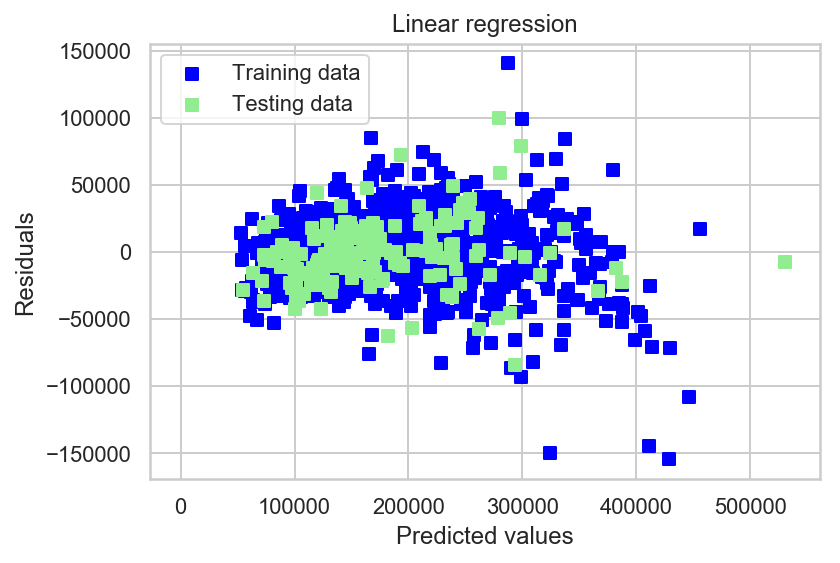

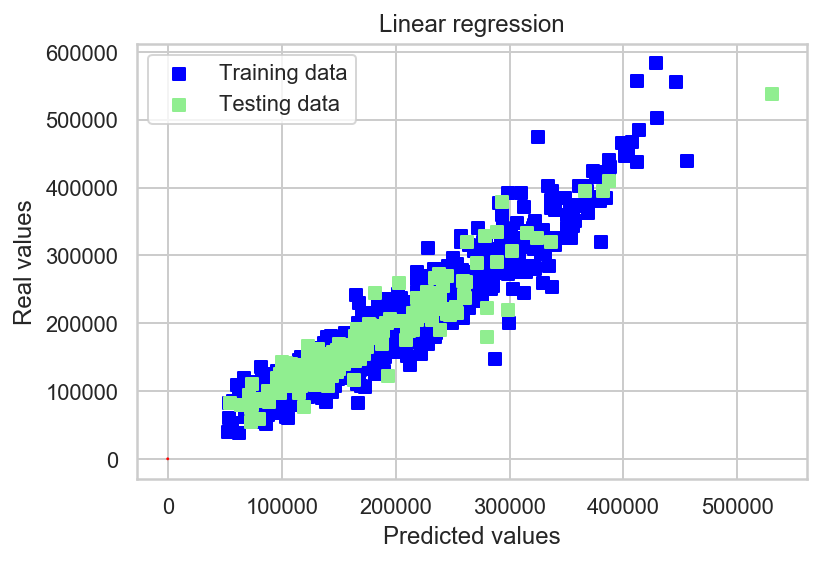

In [140]:
# Look at predictions on training and testing set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Testing data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Testing data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Error is randomly distributed and scattered aroud the centreline. 

#### Linear Regression with cross validation

Cross-validated scores: [ 8.61675648e-01 -7.99544785e+25 -6.84660349e+24 -1.93484338e+26
 -9.25743832e+24]
Cross-Predicted R2: 0.6664689745220971


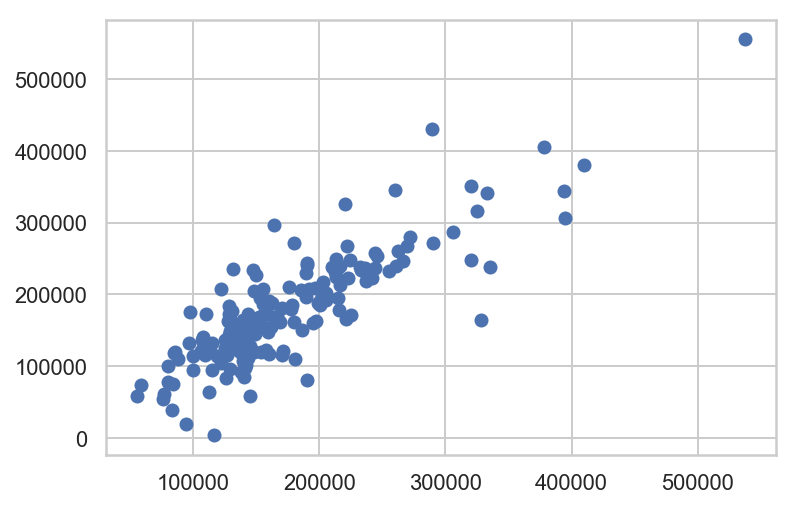

In [149]:
# Perform 5-fold cross validation
scores = cross_val_score(lr, Xs, y_train, cv=5)
print("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=5)
plt.scatter(y_test, predictions)

# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print("Cross-Predicted R2:", r2)

# 3.2 FEATURE SELECTION

In [152]:
# Making a copy of the standardized data frame.
feature_sl = pd.DataFrame()
feature_sl = fixed_df.copy()

In [153]:
# Defining X and y again for feature selection.

# For target variable.
y_select = pd.DataFrame()
cols = list(feature_sl.columns)

y_select['SalePrice'] = fixed_features['SalePrice']
#y_select
# For feature variable.
X_select = pd.DataFrame()
X_select = feature_sl.copy();

In [156]:
print(X_select.shape) # (1450, 148)
print(y_select.shape) # (1444, 1)

(1444, 49)
(1444, 1)


In [157]:
# Defining a function to select the best features

def feature_select_linear_reg(X, y, cv = 10):
    import pandas as pd
    import numpy as np
    # RFECV
    from sklearn.feature_selection import RFECV
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression()

    selector = RFECV(lr, step = 1, cv = cv)
    selector = selector.fit(X, y)

    df_RFECV = pd.DataFrame({'variable_RFECV': X.columns.values.tolist(),
                            'support': selector.support_,
                            'ranking': selector.ranking_}).sort_values('ranking', ascending = True)
    df_RFECV.reset_index(drop = True, inplace = True)
    
    # SelectKbest
    from sklearn.feature_selection import SelectKBest, f_regression
    skb = SelectKBest(f_regression)

    skb.fit(X_train, y_train)

    df_skb = pd.DataFrame({'variable_skb': X.columns.values.tolist(),
                          'score': skb.scores_.tolist()}).sort_values('score', ascending = False)
    df_skb.reset_index(drop = True, inplace = True)
    
    # Lasso
    
    from sklearn.linear_model import Lasso, LassoCV
    optimal_lasso = LassoCV(n_alphas = 500, cv = cv, verbose = 1)
    optimal_lasso.fit(X, y)

    optimal_alpha = optimal_lasso.alpha_
    lasso_coef = optimal_lasso.coef_
    
    df_lasso = pd.DataFrame({'Variable_Lasso': X.columns.values.tolist(),
                            'Coefficients': lasso_coef.tolist(),
                            'CoeffAbs': abs(lasso_coef).tolist()}).sort_values('CoeffAbs', ascending = False)
    df_lasso.reset_index(drop = True, inplace = True)
    
    
    # combine all 3 dataframe
    df = pd.concat([df_RFECV, df_skb], axis = 1)
    df = pd.concat([df, df_lasso], axis = 1)
    
    return df

In [ ]:
feature_df = feature_select_linear_reg(X_select, y_select)

In [835]:
feature_df.head(15)

,variable_RFECV,support,ranking,variable_skb,score,Variable_Lasso,Coefficients,CoeffAbs
0,HouseStyle_1.5Fin,True,1,GrndLivArea,1404.238190,YearBuilt,2.043241e-03,2.043241e-03
1,HouseType_TwnhsE,True,1,GarageCarsCap,1133.127532,YearRemodel,9.620680e-04,9.620680e-04
2,HouseType_Twnhs,True,1,GarageArea,1024.138289,GarageArea,3.653654e-04,3.653654e-04
3,HouseType_Duplex,True,1,TotBsmtArea,872.534140,GrndLivArea,3.109698e-04,3.109698e-04
4,HouseType_2fmCon,True,1,1stFlrArea,752.268343,TotBsmtArea,2.357948e-04,2.357948e-04
5,HouseType_1Fam,True,1,FullBath,692.478464,BsmtFinArea1,9.938678e-05,9.938678e-05
6,MasonVenrType,True,1,YearBuilt,644.913923,WoodDeckArea,8.242693e-05,8.242693e-05
7,MasonVenrArea,True,1,YearRemodel,609.803977,OpenPorchArea,7.518835e-05,7.518835e-05
8,LowQualArea,True,1,TotRmsAbvGrade,510.284102,2ndFlrArea,6.078564e-05,6.078564e-05
9,BsmtFinArea1,True,1,FoundationType_PConc,466.521879,MasonVenrType,2.550180e-05,2.550180e-05


In [844]:
# 1. Using SKbest

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest,chi2

# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_regression, k=5)
#skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_f.fit(X_select, y_select)
#skb_chi2.fit(X_select, y_select)

# examine results
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)

#kbest = pd.DataFrame([cols, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     #index=['feature','f_regression','chi2 score']).T.sort_values('f_regression', ascending=False)
kbest.head(15)


D:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,feature,f_regression
126,GrndLivArea,1582.12
133,GarageCarsCap,1294.68
134,GarageArea,1165.5
123,TotBsmtArea,1024.84
124,1stFlrArea,870.77
129,FullBath,760.599
115,YearBuilt,752.609
116,YearRemodel,668.421
132,TotRmsAbvGrade,579.736
81,FoundationType_PConc,565.772


In [837]:
# 2. Recursive Feature Elimination (RFE)

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFECV(linreg, step=1, cv=10)
selector = selector.fit(X_select, y_select)

print(selector.support_)
print(selector.ranking_)

D:\ANACONDA\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False False  True
  True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False]
[25 27 24 26  8  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  1  5  6  1  1  1  1  1  1  4  

In [353]:
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['ZoneClassify_FV', 'ZoneClassify_RH', 'ZoneClassify_RL',
       'ZoneClassify_RM', 'StreetAccType_Grvl', 'StreetAccType_Pave',
       'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low',
       'LandContour_Lvl', 'UtilitiesAvlType_AllPub',
       'UtilitiesAvlType_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldT

# 3.3. Linear Regression with Regularization - Lasso and Elastic Net
- Characterize your model. How well does it perform? What are the best estimates of price?

In [748]:
# BASELINE ACCURACY

#ss = StandardScaler()
#ss.fit_transform(y)

# np.mean(target_y); # 0.51


In [ ]:
# 3. Using L1 Lasso penalty (Option1)

optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1)
optimal_lasso.fit(X_train, y_train)

alpha = optimal_lasso.alpha_
coef = optimal_lasso.coef_
print('alpha ', alpha, end=' ')


#Cross-validate the Lasso R2R2  with the optimal alpha
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs_train_fixed, y_train_fixed, cv=5)

print('Percent variables zeroed out:', np.sum((coef == 0))/float(X.shape[0]))

#print('mean', np.mean(lasso_scores), end='')
#print('score', lasso_scores)

#Look at the coefficients for variables in the Lasso
lasso_coefs = pd.DataFrame({'variable':X.columns,
                           'coef':coef,
                           'abs_coef':np.abs(coef)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.columns = ['lasso_features', 'lasso_coef', 'lasso_abs_coef']
lasso_coefs.head(15)

Best alpha : 0.003
Try again for more precision with alphas centered around 0.003
Best alpha : 0.00375
Lasso RMSE on Training set : 0.13177650457715057
Lasso RMSE on Test set : 0.13687343107300282


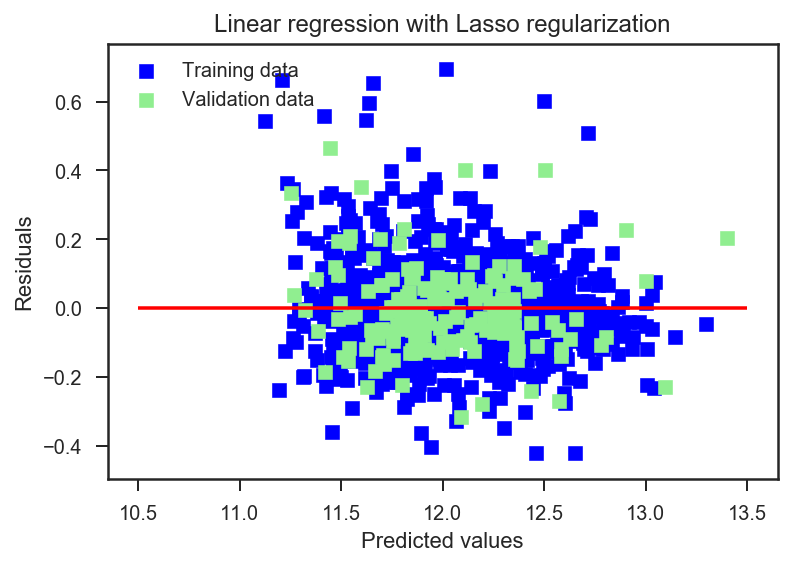

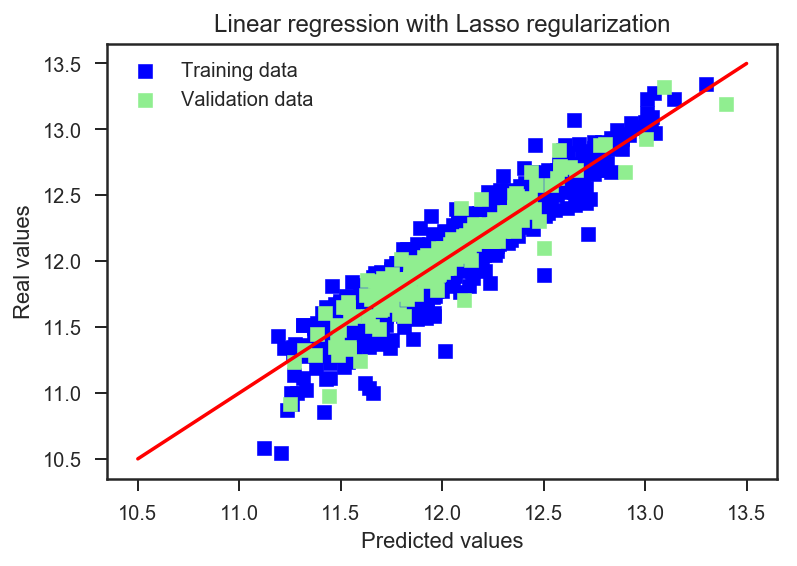

Lasso picked 73 features and eliminated the other 70 features


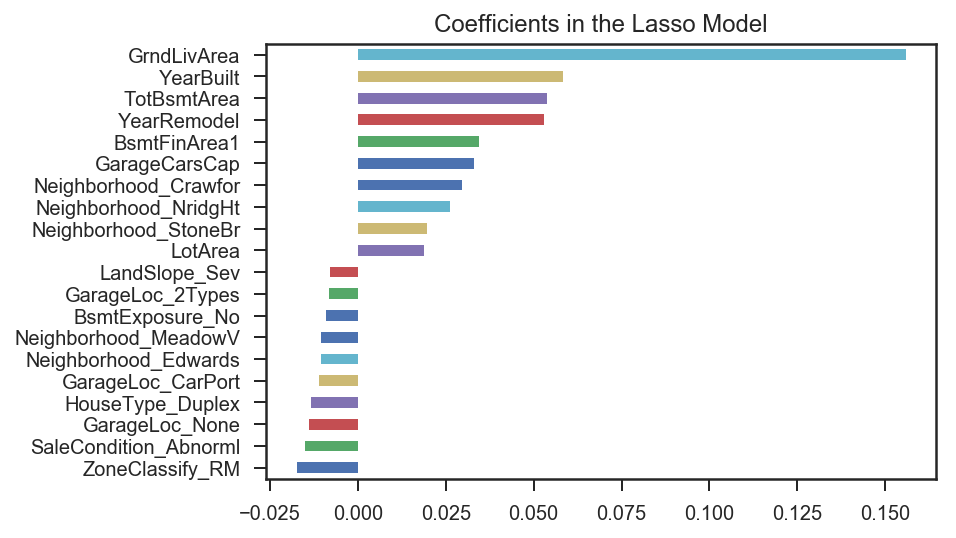

In [793]:
# 4. Using L1 Lasso penalty (Option 2)
# Ref : (https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_select.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

Best l1_ratio : 0.6
Best alpha : 0.006
Try again for more precision with l1_ratio centered around 0.6
Best l1_ratio : 0.63
Best alpha : 0.006
Now try again for more precision on alpha, with l1_ratio fixed at 0.63 and alpha centered around 0.006
Best l1_ratio : 0.63
Best alpha : 0.006
ElasticNet RMSE on Training set : 0.13191805293383277
ElasticNet RMSE on Test set : 0.1352866917053821


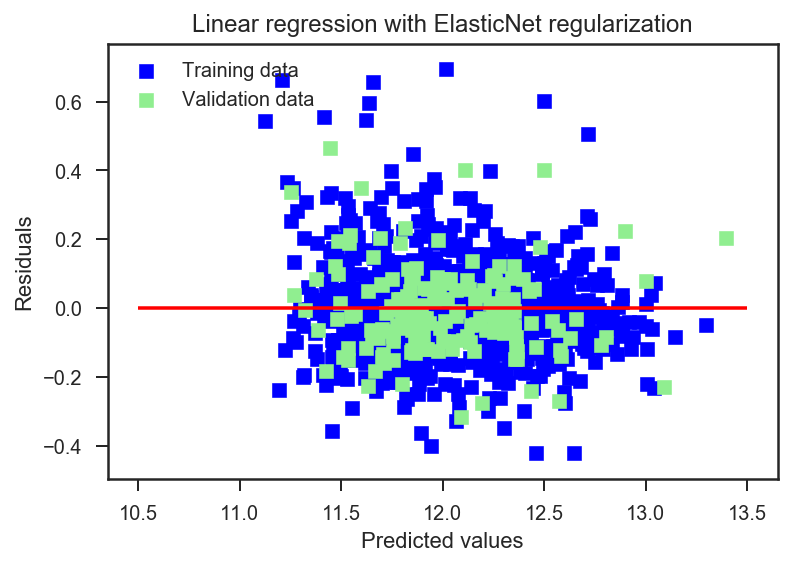

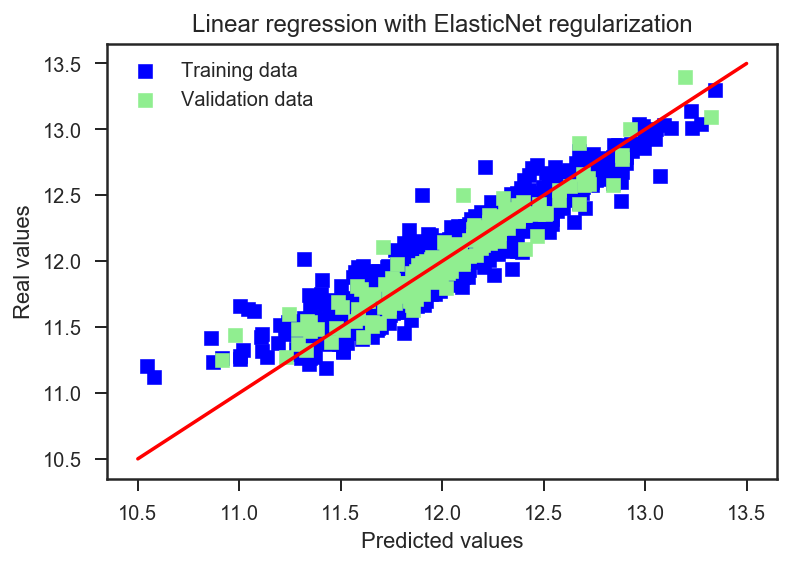

ElasticNet picked 74 features and eliminated the other 69 features


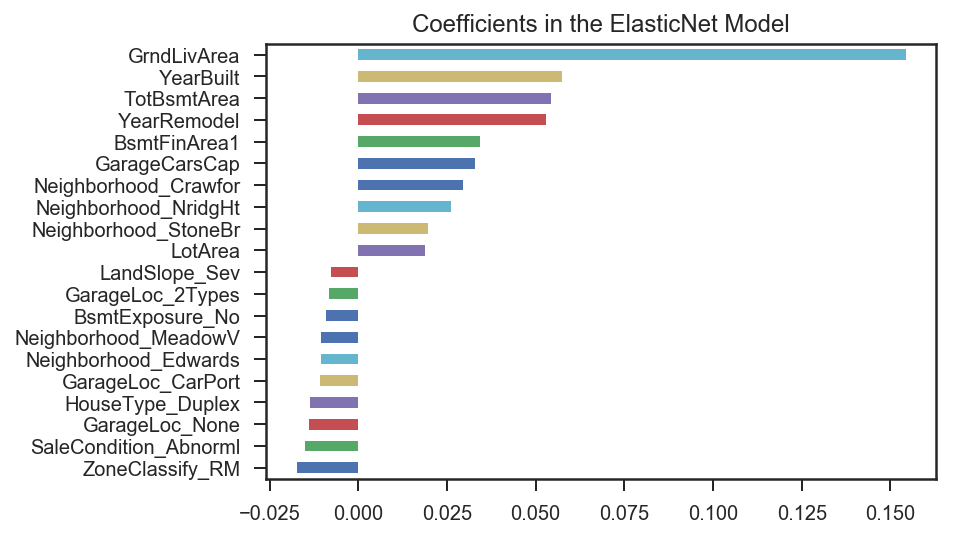

In [747]:
# 5. Linear Regression with Regularization technique -- ElasticNet
# Ref : (https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_select.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [740]:
# 6. Applying the Gradient Boosting Regressor model.
# Ref(https://towardsdatascience.com/create-a-model-to-predict-house-prices-using-python-d34fe8fad88f)

clf = ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5,min_samples_split=2,learning_rate=0.1,loss='ls')

# max_depth — The depth of the tree node.
# learning_rate — Rate of learning the data.
# loss — loss function to be optimized. ‘ls’ refers to least squares regression
# minimum sample split — Number of sample to be split for learning the data

In [741]:
clf.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [743]:
clf_score_train = clf.score(X_train,y_train)
print("The Gradient Boosting Regressor model Accuracy for train data is :", clf_score*100)

The Gradient Boosting Regressor model Accuracy for train data is : 99.56563540280632


In [381]:
clf_score_test = clf.score(X_test_fixed,y_test_fixed)
print("The Gradient Boosting Regressor model Accuracy for test data is :", clf_score_test*100)

The Gradient Boosting Regressor model Accuracy for test data is : 89.11664560444805


# CONCLUSION FOR QUESTION 1 :

1. For Linear Regression model without any regularization.
- RMSE on Training set : 672406930170.8018
- RMSE on Test set : 3745495561493.7803

i) RMSE results are different on both, training and test sets. 
ii) From the predicted v/s actual values plot, the distribution seems randomly distributed around the line.

2. For Linear Regression with Lasso (L1) regularization.
- Lasso RMSE on Training set : 0.13177650457715057
- Lasso RMSE on Test set : 0.13687343107300282

i) RMSE results are better both on training and test sets. 
ii) Lasso used only one third of the available features. 
iii) Also, another observation is about the Neighbourhood features on both ends +ve and -ve (3 types on +ve and 2 types on -ve) which indicates that the Neighbourhood type is one important feature in sale of the house and Sale price differs based on it.
iv) Ground Living Area of the house is the top predictor as per Lasso as seen in the output from the co-eff table and plot.

3. For Linear Regression with Elastic Net regularization.
- ElasticNet RMSE on Training set : 0.13191805293383277
- ElasticNet RMSE on Test set : 0.1352866917053821

i) The optimal L1 ratio used by ElasticNet here is equal to 1, which means it is exactly equal to the Lasso regressor.  
ii) The model didn't need any L2 regularization to overcome any potential L1 shortcoming.


## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [903]:
# Defining the renovateable features as below.

renov_features = []

for col in house.columns:
    #print(col)
    if col in fixed_features:
        pass
    else:
        renov_features.append(col)


print("Number of Renovatable features are :" , len(renov_features))
print()
print(renov_features)

Number of Renovatable features are : 30

['AlleyAccType', 'OverallQual', 'OverallCond', 'YearRemodel', 'RoofStyle', 'RoofMaterial', 'ExteriorType1', 'ExteriorType2', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'HeatingType', 'HeatingQual', 'CentralAir', 'ElectricalSys', 'KitchAbvGrade', 'KitchenQual', 'Functionality', 'FireplCount', 'FireplQual', 'GarageInterior', 'GarageQual', 'GarageCondt', 'PavedDriveway', 'PoolQual', 'FenceQual', 'YrSold']


In [904]:
type(renov_features)

list

In [905]:
# Define renovation features in a data frame and extract data from the main dataframe - house.

reno_df = pd.DataFrame(data=house,columns=renov_features)
print(reno_df.shape)
reno_df.head(10)

(1446, 30)


,AlleyAccType,OverallQual,OverallCond,YearRemodel,RoofStyle,RoofMaterial,ExteriorType1,ExteriorType2,ExterQual,ExterCond,...,Functionality,FireplCount,FireplQual,GarageInterior,GarageQual,GarageCondt,PavedDriveway,PoolQual,FenceQual,YrSold
0,None,7,5,2003,Gable,CompShg,VinylSd,VinylSd,Gd,TA,...,Typ,0,None,RFn,TA,TA,Y,None,None,2008
1,None,6,8,1976,Gable,CompShg,MetalSd,MetalSd,TA,TA,...,Typ,1,TA,RFn,TA,TA,Y,None,None,2007
2,None,7,5,2002,Gable,CompShg,VinylSd,VinylSd,Gd,TA,...,Typ,1,TA,RFn,TA,TA,Y,None,None,2008
3,None,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,...,Typ,1,Gd,Unf,TA,TA,Y,None,None,2006
4,None,8,5,2000,Gable,CompShg,VinylSd,VinylSd,Gd,TA,...,Typ,1,TA,RFn,TA,TA,Y,None,None,2008
5,None,5,5,1995,Gable,CompShg,VinylSd,VinylSd,TA,TA,...,Typ,0,None,Unf,TA,TA,Y,None,MnPrv,2009
6,None,8,5,2005,Gable,CompShg,VinylSd,VinylSd,Gd,TA,...,Typ,1,Gd,RFn,TA,TA,Y,None,None,2007
7,None,7,6,1973,Gable,CompShg,HdBoard,HdBoard,TA,TA,...,Typ,2,TA,RFn,TA,TA,Y,None,None,2009
8,None,7,5,1950,Gable,CompShg,BrkFace,Wd Shng,TA,TA,...,Min1,2,TA,Unf,Fa,TA,Y,None,None,2008
9,None,5,6,1950,Gable,CompShg,MetalSd,MetalSd,TA,TA,...,Typ,2,TA,RFn,Gd,TA,Y,None,None,2008


In [906]:
# Target variable
y_reno = reno_df.YearRemodel

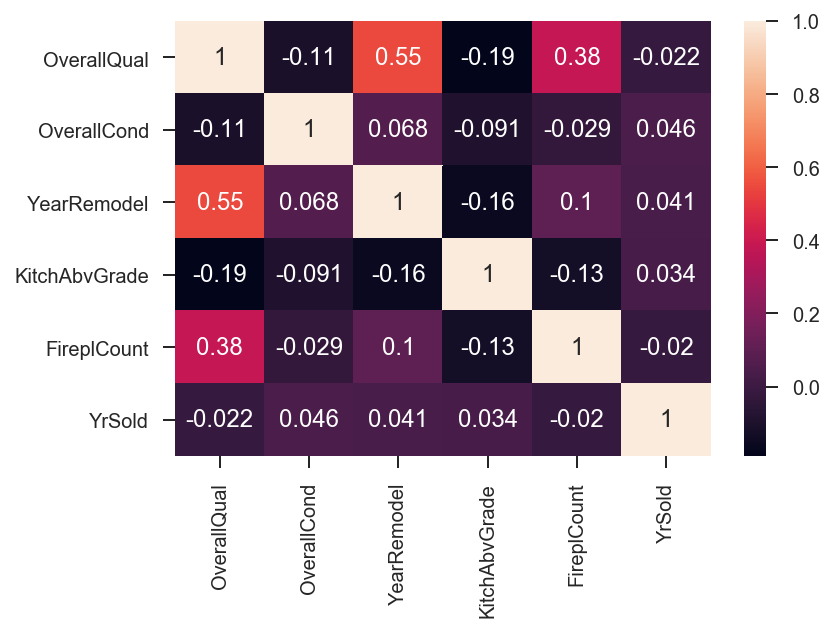

In [907]:
# Check the coorelation betwenn the reno variables.

corrl=reno_df.corr()
sns.heatmap(corrl, annot=True)

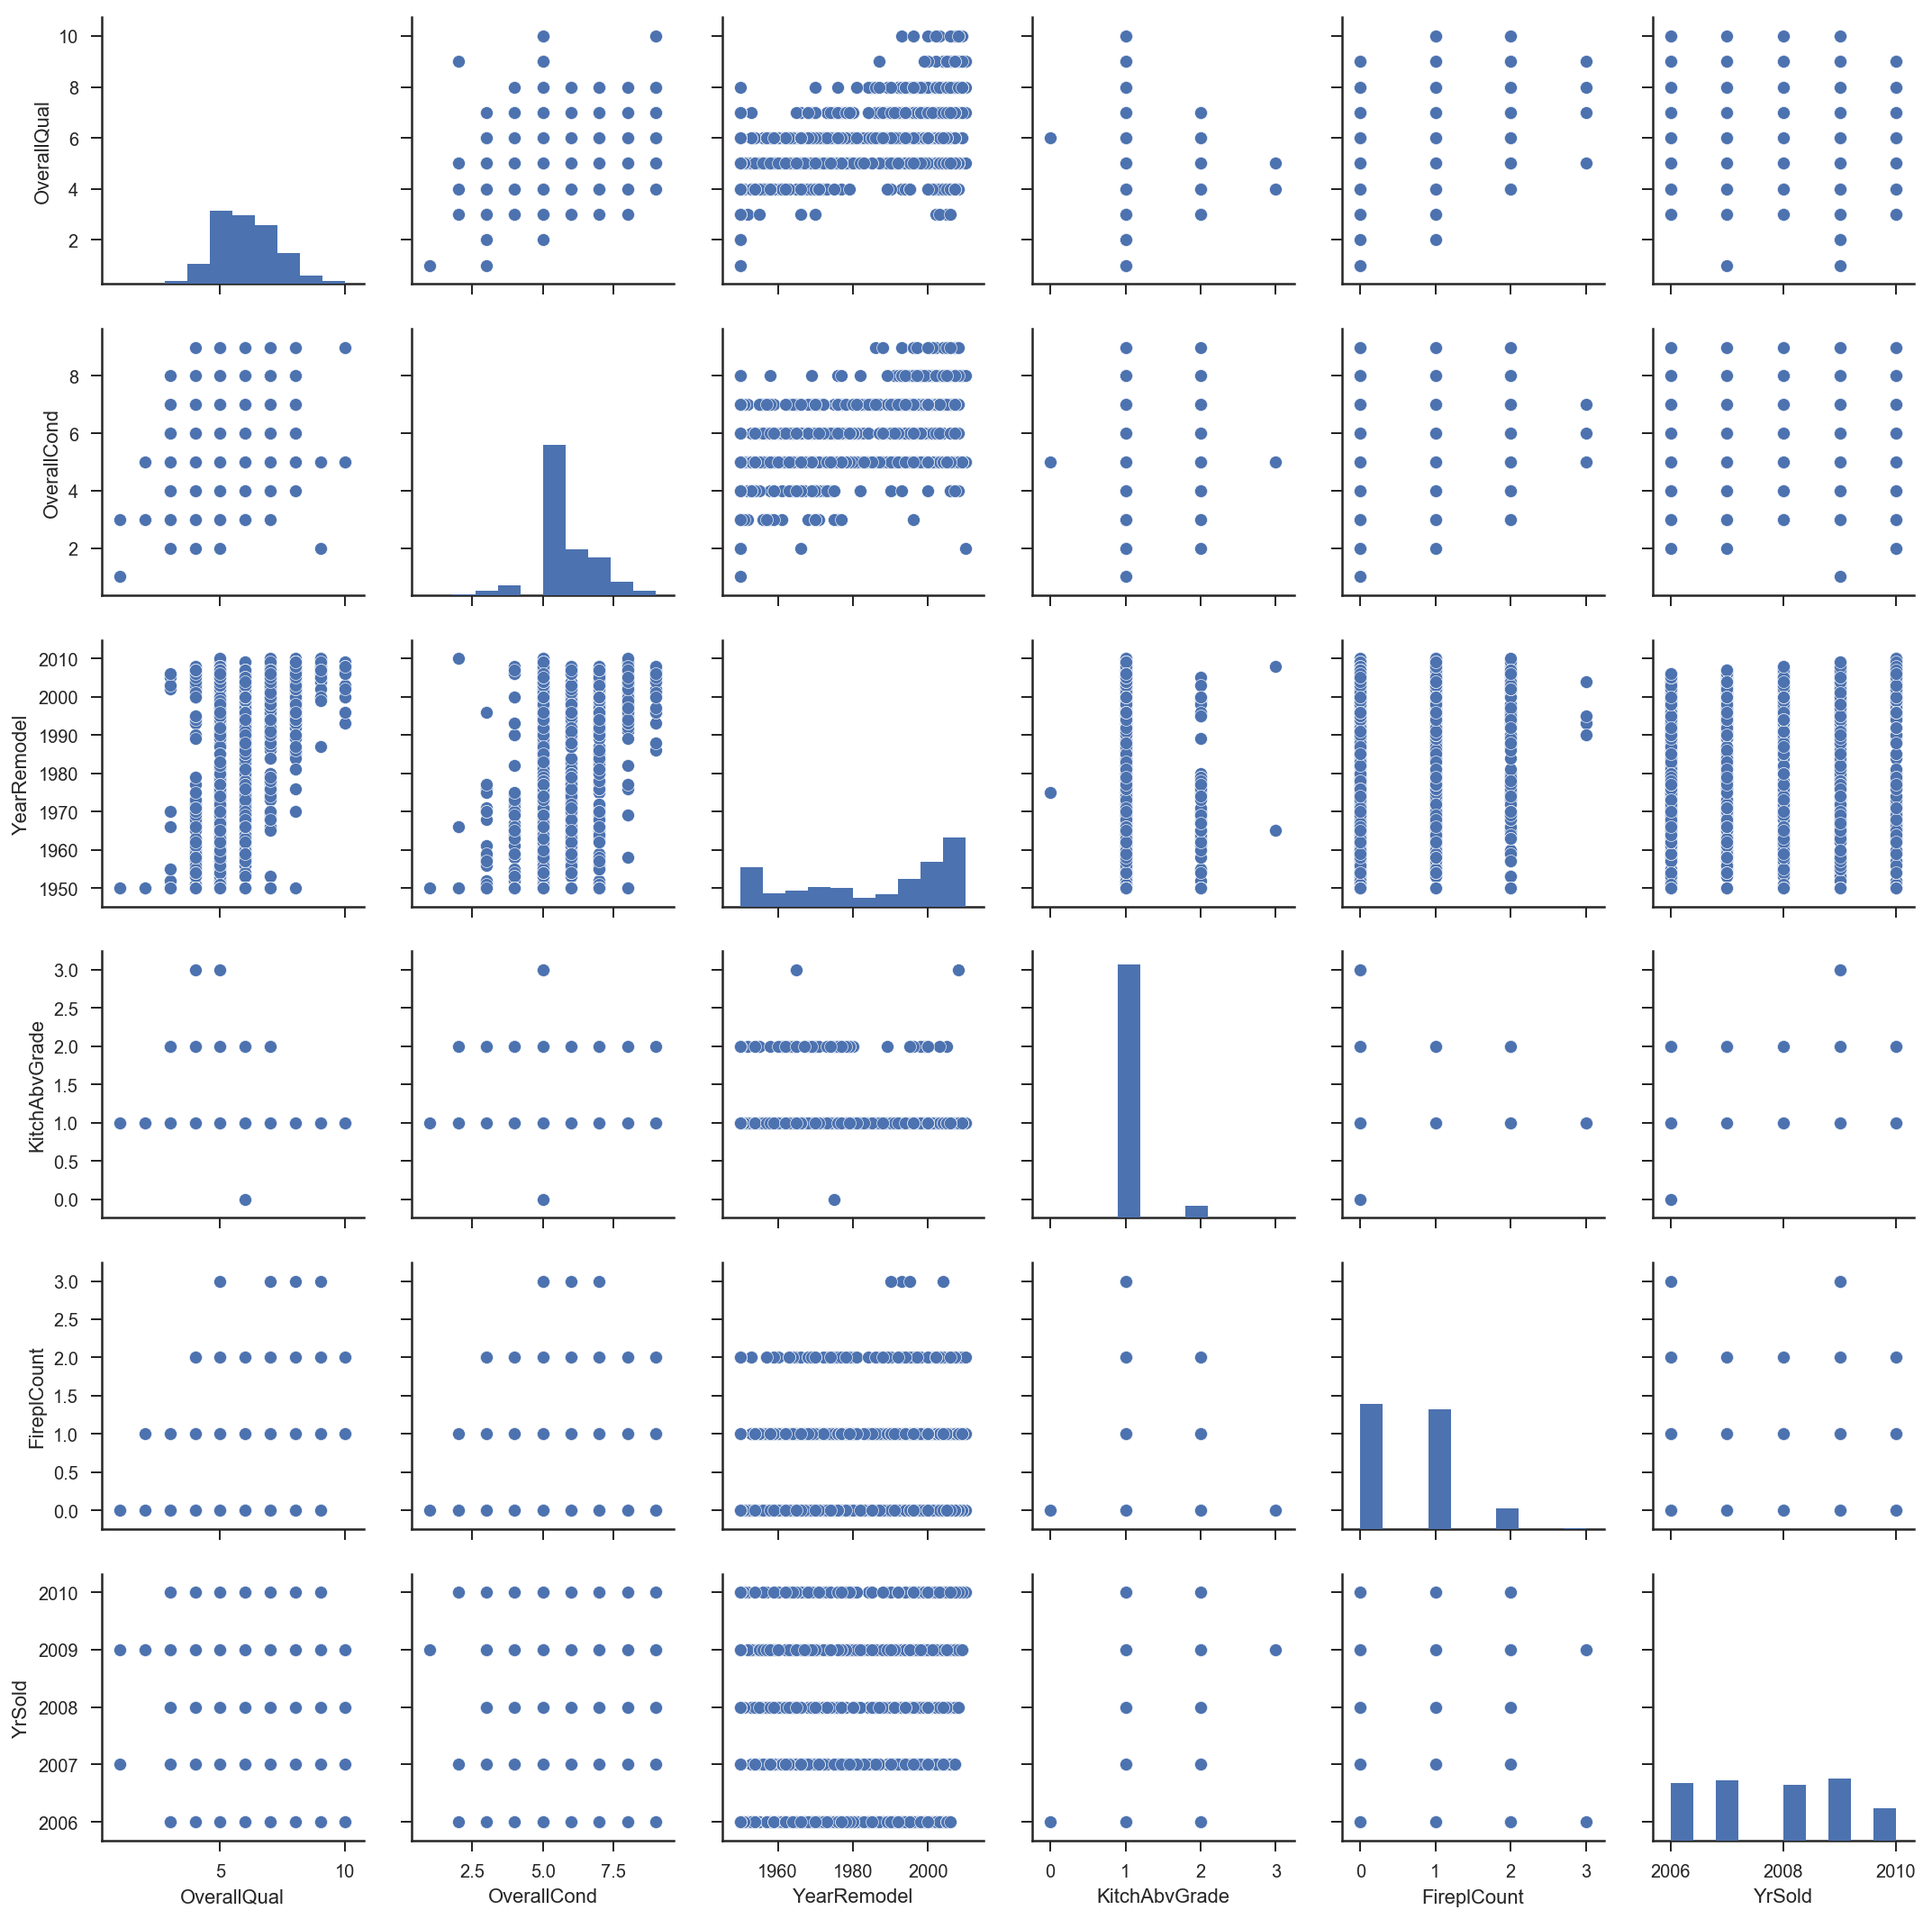

In [908]:
# Using pairplot
sns.pairplot(reno_df)

In [911]:
print("The most important features relative to target")
corr1 = reno_df.corr()
corr1.sort_values(["YearRemodel"], ascending = False, inplace = True)
print(corr1.YearRemodel)
#this you can see at the time of heatmap and pairplot also.

The most important features relative to target
YearRemodel      1.000000
OverallQual      0.545123
FireplCount      0.100662
OverallCond      0.068448
YrSold           0.041275
KitchAbvGrade   -0.155381
Name: YearRemodel, dtype: float64


In [912]:
# Categorical features
categorical_reno_features = reno_df.select_dtypes(include=['object']).columns
categorical_reno_features

Index(['AlleyAccType', 'RoofStyle', 'RoofMaterial', 'ExteriorType1',
       'ExteriorType2', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingType', 'HeatingQual',
       'CentralAir', 'ElectricalSys', 'KitchenQual', 'Functionality',
       'FireplQual', 'GarageInterior', 'GarageQual', 'GarageCondt',
       'PavedDriveway', 'PoolQual', 'FenceQual'],
      dtype='object')

In [913]:
# Numerical features
numerical_reno_features = reno_df.select_dtypes(exclude = ["object"]).columns
numerical_reno_features

Index(['OverallQual', 'OverallCond', 'YearRemodel', 'KitchAbvGrade',
       'FireplCount', 'YrSold'],
      dtype='object')

In [914]:
# Differentiate numerical features (dropping the target) and categorical features
categorical_reno_features = reno_df.select_dtypes(include = ["object"]).columns
numerical_reno_features = reno_df.select_dtypes(exclude = ["object"]).columns
numerical_reno_features = numerical_reno_features.drop("YearRemodel")

print("Numerical reno features: " + str(len(numerical_reno_features)))
print("Categorical reno features : " + str(len(categorical_reno_features)))

df_num_reno = reno_df[numerical_reno_features]
df_cat_reno = reno_df[categorical_reno_features]

Numerical reno features: 5
Categorical reno features : 24


In [915]:
# Now,we simply used median() to fill na values in numerical features
print("NAs for numerical features in the dataframe : " + str(df_num_reno.isnull().values.sum()))

df_num_reno = df_num_reno.fillna(df_num_reno.median())

print("Remaining NAs for numerical features in the dataframe : " + str(df_num_reno.isnull().values.sum()))

NAs for numerical features in the dataframe : 0
Remaining NAs for numerical features in the dataframe : 0


In [916]:
df_cat_reno.shape

(1446, 24)

In [917]:
# Create dummy features for categorical values
df_cat_reno = pd.get_dummies(df_cat_reno)
df_cat_reno.shape

(1446, 144)

In [918]:
df_cat_reno.head()

,AlleyAccType_Grvl,AlleyAccType_None,AlleyAccType_Pave,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMaterial_CompShg,...,PavedDriveway_Y,PoolQual_Ex,PoolQual_Fa,PoolQual_Gd,PoolQual_None,FenceQual_GdPrv,FenceQual_GdWo,FenceQual_MnPrv,FenceQual_MnWw,FenceQual_None
0,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [1000]:
# Earlier we split the dataset into categorical and numerical features.Now after preprocessing we'll join them to get the whole 
# dataset back.
train_r = pd.concat([df_cat_reno,df_num_reno],axis=1)
train_r.shape

(1446, 149)

# Split train-test data

In [1005]:
# Partition the dataset in train + validation sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(train_r, y_reno, test_size = 0.3, random_state = 0)

print("X_train : " + str(X_train_r.shape))
print("X_test : " + str(X_test_r.shape))
print("y_train : " + str(y_train_r.shape))
print("y_test : " + str(y_test_r.shape))

X_train : (1012, 149)
X_test : (434, 149)
y_train : (1012,)
y_test : (434,)


In [1006]:
X_train_r.head(2)

,AlleyAccType_Grvl,AlleyAccType_None,AlleyAccType_Pave,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMaterial_CompShg,...,FenceQual_GdPrv,FenceQual_GdWo,FenceQual_MnPrv,FenceQual_MnWw,FenceQual_None,OverallQual,OverallCond,KitchAbvGrade,FireplCount,YrSold
876,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,4,5,1,0,2007
441,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,4,4,2,0,2008


In [1007]:
y_train_r.head(2)

876    1963
441    1955
Name: YearRemodel, dtype: int64

In [1008]:
# Standardize the numerical features.

from sklearn.preprocessing import StandardScaler
ssr = StandardScaler()

X_train_r.loc[:, numerical_reno_features] = ssr.fit_transform(X_train_r.loc[:, numerical_reno_features])

X_test_r.loc[:, numerical_reno_features] = ssr.transform(X_test_r.loc[:, numerical_reno_features])

D:\ANACONDA\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [1014]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_r, y_train_r, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test_r, y_test_r, scoring = scorer, cv = 10))
    return(rmse)

In [1009]:
# Check all the unique values of the 'YrSold'
train_r.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

# Linear Regression without regularization

In [1018]:
lm = LinearRegression()
lm.fit(X_train_r,y_train_r)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1019]:
lm.score(X_train_r,y_train_r)

0.6716424797904118

In [1020]:
lm.score(X_test_r,y_test_r)

-2.834038522969818e+21

In [1022]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_r, y_train_r, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test_r, y_test_r, scoring = scorer, cv = 10))
    return(rmse)

RMSE on Training set : 3133212958104.2295
RMSE on Test set : 21671634135611.914


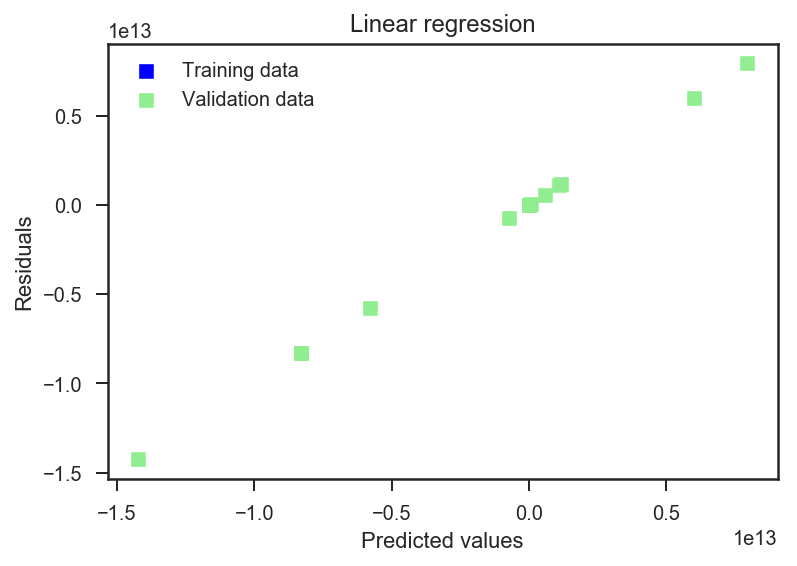

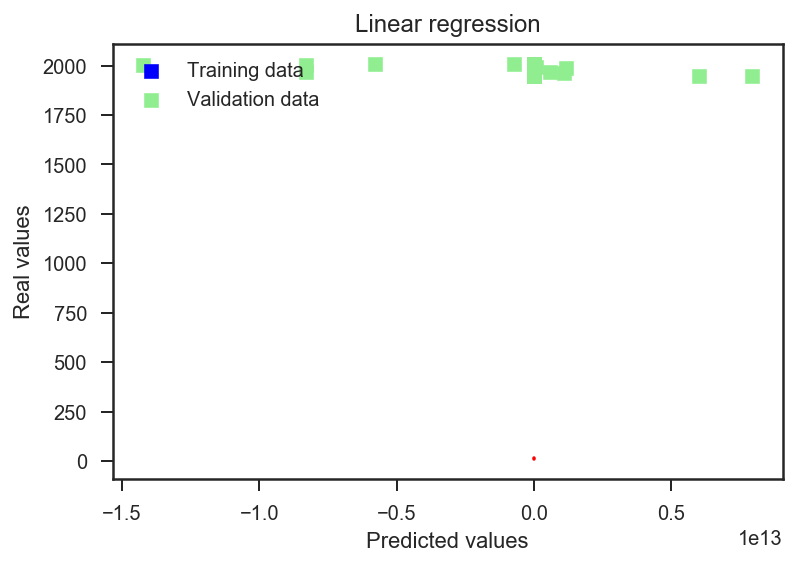

In [1023]:
# Look at predictions on training and validation set

print("RMSE on Training set :", rmse_cv_train(lm).mean())
print("RMSE on Test set :", rmse_cv_test(lm).mean())
y_train_predr = lm.predict(X_train_r)
y_test_predr = lm.predict(X_test_r)

# Plot residuals
plt.scatter(y_train_predr, y_train_predr - y_train_r, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_predr, y_test_predr - y_test_r, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_predr, y_train_r, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_predr, y_test_r, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [1029]:
y_predr = lm.predict(X_test_r)
rmse = np.sqrt(metrics.mean_squared_error(y_predr, y_test_r))
rmse

1046720936663.1274

Cross-validated scores: [-2.49416495e+22 -2.92120923e+22 -1.77342740e+24 -1.21165018e+22
 -1.61859122e+18]


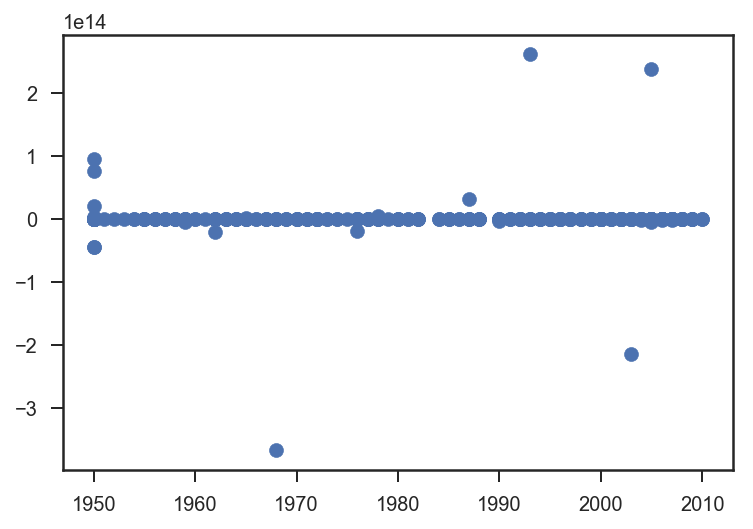

In [1025]:
#from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 5-fold cross validation
scores = cross_val_score(lm, X_train_r, y_train_r, cv=5)
print("Cross-validated scores:", scores)

# Make cross validated predictions on the test sets
predictions_r = cross_val_predict(lm, X_test_r, y_test_r, cv=5)
plt.scatter(y_test_r, predictions_r)

# manually calcualte the r2
r2 = metrics.r2_score(y_test_r, predictions_r)

In [ ]:
# As per instructions, evaluate model's performance on the test (2010) data
# Make predictions on the test (2010) set

#y_pred = lm.predict(X_test)

In [1030]:
# Calculate R2 for test 
from sklearn.metrics import r2_score

r2_test_r = r2_score(y_test_r, y_predr)
print(r2_test_r)

-2.834038522969818e+21


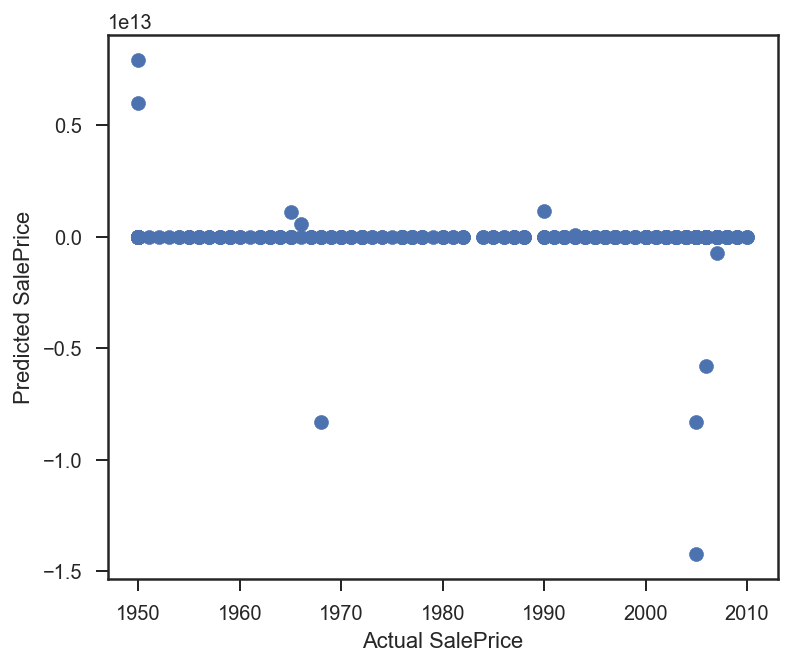

In [1031]:
#Plot the predictive values vs actual values for test (2010)
plt.figure(figsize=(6,5))
plt.scatter(y_test_r, y_predr)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice",)
plt.show()

D:\ANACONDA\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


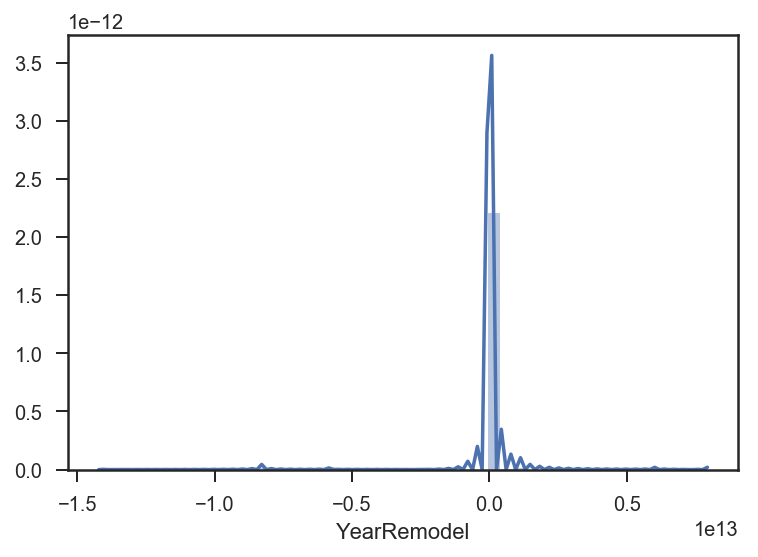

In [1032]:
# Plot the distibution of residuals
residual_test = y_predr - y_test_r
sns.distplot(residual_test)

In [1033]:
# Find the best predictors by examining coefficients of Linear Regression on test
lm_train_coefs = pd.DataFrame({'variable':X_train_r.columns,
                            'coef':lm.coef_,
                            'abs_coef':np.abs(lm.coef_)})

lm_train_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [1045]:
# Defining X and y again for feature selection.

# For target variable.
y_select_r = pd.DataFrame()
columns = list(feature_sl.columns)

y_select_r['YearRemodel'] = reno_df['YearRemodel']
#y_select

# For feature variable.
X_select_r = pd.DataFrame()
X_select_r = reno_df.copy()
X_select_r.drop('YearRemodel',axis=1,inplace=True)
X_select_r.columns

Index(['AlleyAccType', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMaterial', 'ExteriorType1', 'ExteriorType2', 'ExterQual',
       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingType', 'HeatingQual', 'CentralAir', 'ElectricalSys',
       'KitchAbvGrade', 'KitchenQual', 'Functionality', 'FireplCount',
       'FireplQual', 'GarageInterior', 'GarageQual', 'GarageCondt',
       'PavedDriveway', 'PoolQual', 'FenceQual', 'YrSold'],
      dtype='object')

In [1048]:
print(X_select_r.shape) # (1446, 29)
print(y_select_r.shape) # (1446, 1)

(1446, 29)
(1446, 1)


Best alpha : 0.06
Try again for more precision with alphas centered around 0.06
Best alpha : 0.06899999999999999
Lasso RMSE on Training set : 13.263533688750348
Lasso RMSE on Test set : 12.962683691180803


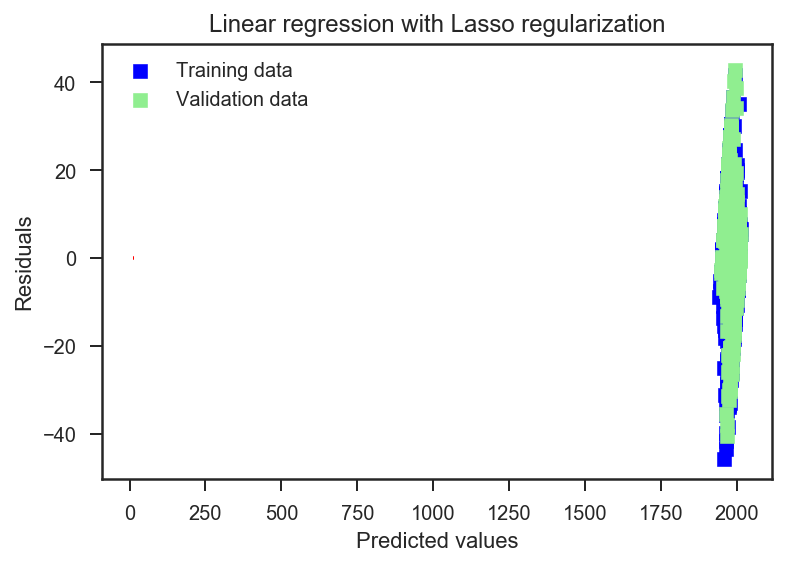

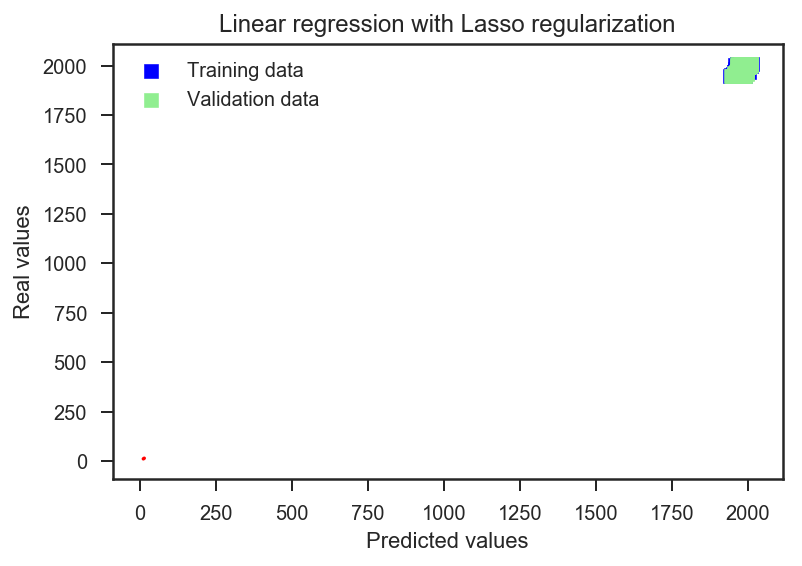

Lasso picked 52 features and eliminated the other 97 features


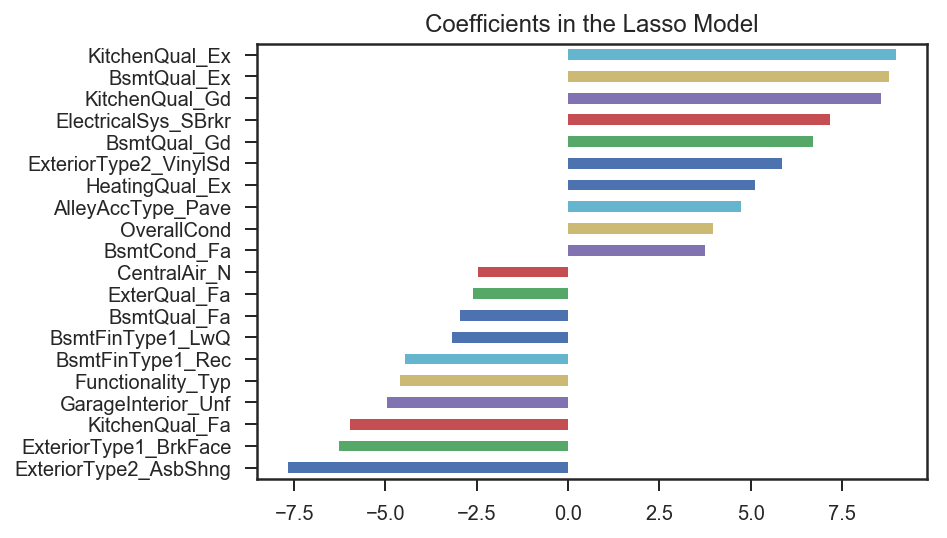

In [1057]:
# 4. Using L1 Lasso penalty (Option 2)
# Ref : (https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_r, y_train_r)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_r, y_train_r)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train_r)
y_test_las = lasso.predict(X_test_r)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train_r, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test_r, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train_r, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_r, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_r.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# CONCLUSION FOR QUESTION 2 :

1. For Linear Regression model without any regularization.
- RMSE on Training set : 3133212958104.2295
- RMSE on Test set : 21671634135611.914

i) RMSE results are different on both, training and test sets. 
ii) From the predicted v/s actual values plot, the distribution seems randomly distributed around the line.

2. For Linear Regression with Lasso (L1) regularization.
- Lasso RMSE on Training set : 13.263533688750348
- Lasso RMSE on Test set : 12.962683691180803

As observed from the feature's co-efficients plot that requires renovation, Kitchen Quality excellent and good, Basement Quality
excellent and good will be the top variables for renovation alongwith type of Electrical and Heating systems installed in the house.

**Q.How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.**

Ans : The second model more towards which are the renovated features people would want or look while buying a house and the first model is about the actual house and surroundings that would determine the SalePrice.
With the knowledge of the top predictors for SalePrice and Year of renovation, I can conclude that with reasonable size of house plot and excellent quality kitchen the company can make money.


**Q. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?**

Ans : Both linear regression models using lasoo regularization technique, can help to indicate the top predictors to sell the property by target as SalePrice and for buying properties by target as Renovated year for selling properties.

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1063]:
house['SaleCondition'].value_counts()

Normal     1193
Partial     123
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [1064]:
df_SP = house.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
df_SP

,SalePrice
SaleCondition,
Abnorml,135000
AdjLand,104000
Alloca,153337
Family,140500
Normal,160000
Partial,246578


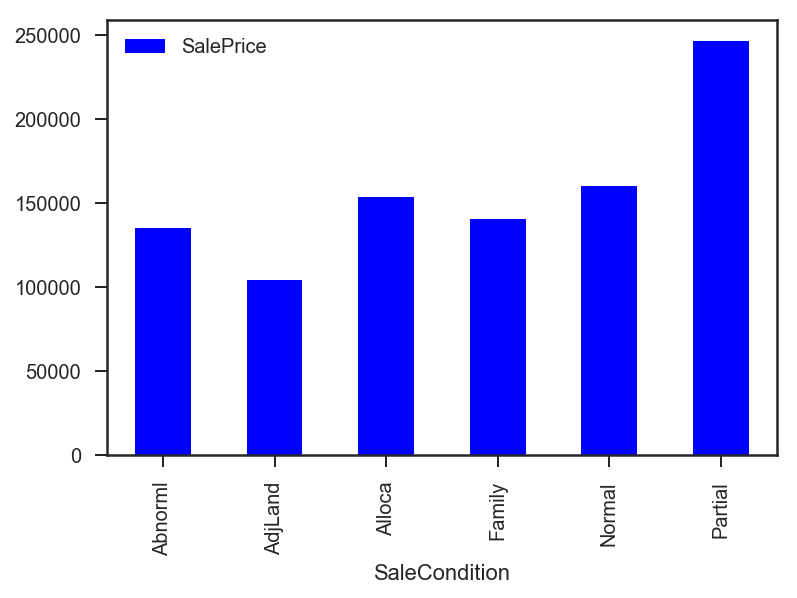

In [1066]:
df_SP.plot(kind='bar',color='blue')

In [1069]:
# Dummify
df_new = pd.get_dummies(df_SP)
df_new

,SalePrice
SaleCondition,
Abnorml,135000
AdjLand,104000
Alloca,153337
Family,140500
Normal,160000
Partial,246578
